# Predicción de Consumo Energético usando Machine Learning

Modelos de regresión basados en machine learning para predecir consumo energético usando variables como: 'ID_Cliente', 'Sector', 'Consumo_kWh_Mensual', 'Estrato', 'Ciudad', 'Area_m2', 'Factura_Mensual_COP', 'Puede_Pagar_Solar', las cuales fueron previamente preprocesadas a través de limpieza de outliers en Excel usando el método IQR

*Resumen general* 

Este notebook entrena y compara modelos de regresión para predecir el consumo energético mensual (kWh) a partir de variables como sector, estrato, ciudad, área y capacidad de pago.

Estructura del código
1. Carga y exploración de datos
Carga datos desde un Excel (Paneles_solares_con_outliers.xlsx)
460 registros con 9 columnas
Analiza distribuciones, correlaciones y valores nulos

2. Preprocesamiento
Elimina columnas no predictoras (ID_Cliente, Validar, Factura_Mensual_COP)
Codifica variables categóricas (Sector, Ciudad, Puede_Pagar_Solar)
Imputa valores nulos
Divide los datos: 70% entrenamiento, 30% prueba
Estandariza las características numéricas

3. Entrenamiento de modelos
Evalúa 7 modelos de regresión:
Regresión Lineal
Ridge
Lasso
ElasticNet
Árbol de Decisión
Random Forest
Gradient Boosting
Cada modelo se optimiza con GridSearchCV y se evalúa con:
R² Score
RMSE (Error Cuadrático Medio)
MAE (Error Absoluto Medio)
Validación cruzada (5 folds)

4. Comparación y selección
Compara todos los modelos
Selecciona el mejor según R² de test (validación con 30% de datos de prueba)
Resultado: Random Forest (R² = 0.8530) , este fue el mejor resultado.

5. Visualizaciones
Gráficos de comparación de métricas
Predicciones vs valores reales
Análisis de residuos
Dashboard con múltiples visualizaciones

6. Generación de reportes
Reporte Excel con 4 hojas:
Resumen Ejecutivo
Comparación de Modelos
Predicciones y Errores
Variables Predictoras

7. Guardado del modelo
Guarda el modelo entrenado (.pkl)
Guarda el escalador y otros objetos necesarios
Genera metadatos en JSON

8. Sistema de predicción
Función predecir_desde_excel() para hacer predicciones con datos nuevos
Crea plantillas Excel de ejemplo
Genera reportes de predicciones
Resultado principal
El mejor modelo es Random Forest con:
R² Score: 0.8530 (explica el 85.3% de la varianza)
RMSE: 968.78 kWh

Conclusión: Variable más importante: Area_m2 (97.5% de importancia)
El código está listo para predecir el consumo energético con nuevos datos, y en este caso la predicción se hará con base en las variables seleccionadas, donde el 97.5% es el peso de la variable más importante.

*A continuación los pasos para obtener el resultado*

0. Cómo cargar las librerias necesarias para el programa

In [1]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS NECESARIAS PARA EL PROYECTO
# ============================================================================

# --- LIBRERÍAS PARA MANIPULACIÓN Y ANÁLISIS DE DATOS ---
# pandas: Biblioteca principal para trabajar con DataFrames (tablas de datos)
#         Permite leer Excel, filtrar, transformar y analizar datos fácilmente
import pandas as pd

# numpy: Biblioteca para operaciones matemáticas y numéricas
#        Proporciona arrays multidimensionales y funciones matemáticas eficientes
import numpy as np

# --- LIBRERÍAS PARA VISUALIZACIÓN DE DATOS ---
# matplotlib: Biblioteca base para crear gráficos y visualizaciones
#             Permite crear gráficos de líneas, barras, scatter plots, etc.
import matplotlib.pyplot as plt

# seaborn: Biblioteca de visualización estadística basada en matplotlib
#          Proporciona gráficos más atractivos y estadísticos (heatmaps, distribuciones, etc.)
import seaborn as sns

# --- LIBRERÍAS DE MACHINE LEARNING (scikit-learn) ---
# sklearn.model_selection: Funciones para dividir datos y validar modelos
from sklearn.model_selection import train_test_split  # Divide datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV      # Busca los mejores hiperparámetros
from sklearn.model_selection import cross_val_score   # Realiza validación cruzada

# sklearn.preprocessing: Funciones para preprocesar datos antes del modelado
from sklearn.preprocessing import StandardScaler   # Estandariza variables numéricas (media=0, std=1)
from sklearn.preprocessing import LabelEncoder    # Convierte variables categóricas a numéricas

# sklearn.linear_model: Modelos de regresión lineal
from sklearn.linear_model import LinearRegression  # Regresión lineal simple
from sklearn.linear_model import Ridge            # Regresión Ridge (regularización L2)
from sklearn.linear_model import Lasso            # Regresión Lasso (regularización L1)
from sklearn.linear_model import ElasticNet       # Regresión ElasticNet (L1 + L2)

# sklearn.tree: Modelos basados en árboles de decisión
from sklearn.tree import DecisionTreeRegressor     # Árbol de decisión para regresión

# sklearn.ensemble: Modelos de ensamble (combinan múltiples modelos)
from sklearn.ensemble import RandomForestRegressor      # Random Forest (múltiples árboles)
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting (árboles secuenciales)

# sklearn.metrics: Métricas para evaluar el rendimiento de los modelos
from sklearn.metrics import mean_squared_error  # Error cuadrático medio (RMSE se calcula con sqrt)
from sklearn.metrics import r2_score           # Coeficiente de determinación R²
from sklearn.metrics import mean_absolute_error # Error absoluto medio (MAE)

# sklearn.impute: Funciones para manejar valores faltantes
from sklearn.impute import SimpleImputer  # Imputa valores nulos (puede usar media, mediana, moda)

# --- LIBRERÍAS PARA TRABAJAR CON ARCHIVOS EXCEL ---
# openpyxl: Permite leer, escribir y formatear archivos Excel (.xlsx)
from openpyxl import Workbook              # Crea nuevos archivos Excel
from openpyxl.styles import Font           # Estilos de fuente (negrita, tamaño, color)
from openpyxl.styles import PatternFill    # Colores de fondo de celdas
from openpyxl.styles import Alignment      # Alineación de texto en celdas
from openpyxl.styles import Border, Side   # Bordes de celdas

# --- CONFIGURACIÓN DE ADVERTENCIAS ---
# warnings: Controla las advertencias que muestra Python
import warnings
warnings.filterwarnings('ignore')  # Ignora todas las advertencias para que no aparezcan en la salida
# Nota: Esto es útil para tener una salida más limpia, pero en desarrollo es mejor ver las advertencias

# Mensaje de confirmación
print("El script continúa...")

# --- CONFIGURACIÓN DE ESTILOS PARA GRÁFICOS ---
# Establece el estilo visual de los gráficos de matplotlib
plt.style.use('seaborn-v0_8')  # Usa el estilo 'seaborn' para gráficos más atractivos

# Establece la paleta de colores para seaborn
sns.set_palette("husl")  # Paleta de colores "husl" (Hue-Saturation-Lightness) - colores vibrantes y distinguibles

El script continúa...


## 1. Carga de Datos

In [2]:
# ============================================================================
# CARGA DE DATOS DESDE ARCHIVO EXCEL
# ============================================================================

# pd.read_excel(): Lee un archivo Excel y lo convierte en un DataFrame de pandas
# Parámetros:
#   - 'Paneles_solares_con_outliers.xlsx': Nombre del archivo Excel a leer
#   - sheet_name='Datos Limpios': Especifica qué hoja del Excel leer
#                                  (el archivo puede tener múltiples hojas)
# El resultado se guarda en la variable 'df' (DataFrame)
df = pd.read_excel('Paneles_solares_con_outliers.xlsx', sheet_name='Datos Limpios')

# df.shape: Retorna una tupla con (número_de_filas, número_de_columnas)
# Ejemplo: (460, 9) significa 460 filas (registros) y 9 columnas (variables)
print(f"Forma del dataset: {df.shape}")

# df.columns.tolist(): Obtiene los nombres de todas las columnas y los convierte en una lista
# Esto es útil para ver qué variables tenemos disponibles en el dataset
print(f"\nColumnas: {df.columns.tolist()}")

# df.head(): Muestra las primeras 5 filas del DataFrame por defecto
# Útil para hacer una inspección rápida de los datos
# Alternativas:
#   - df.head(10): Muestra las primeras 10 filas
#   - df.tail(): Muestra las últimas 5 filas
#   - df.tail(10): Muestra las últimas 10 filas
df.head()

Forma del dataset: (460, 9)

Columnas: ['ID_Cliente', 'Sector', 'Consumo_kWh_Mensual', 'Estrato', 'Ciudad', 'Area_m2', 'Factura_Mensual_COP', 'Puede_Pagar_Solar', 'Validar']


,ID_Cliente,Sector,Consumo_kWh_Mensual,Estrato,Ciudad,Area_m2,Factura_Mensual_COP,Puede_Pagar_Solar,Validar
0,RES-0001,Residencial,209.802849,4,Planeta Rica,77.234714,130077.766492,No,VALIDO
1,RES-0002,Residencial,108.131614,1,Sahagún,122.833169,67041.600932,No,VALIDO
2,RES-0003,Residencial,196.742478,4,Planeta Rica,100.210306,121980.336070,No,VALIDO
3,RES-0004,Residencial,145.147312,2,Lorica,69.496604,89991.333414,No,VALIDO
4,RES-0005,Residencial,181.333310,3,Lorica,71.444142,112426.651950,No,VALIDO


## 2. Análisis Exploratorio de Datos

In [3]:
# ============================================================================
# INFORMACIÓN GENERAL DEL DATASET
# ============================================================================

# Imprime un título para identificar la sección
print("=== INFORMACIÓN GENERAL ===")

# df.info(): Proporciona un resumen completo del DataFrame
# Muestra:
#   - Número total de filas (entries)
#   - Número de columnas y sus nombres
#   - Cantidad de valores no nulos (Non-Null Count) por columna
#   - Tipo de dato de cada columna (Dtype)
#   - Uso de memoria (memory usage)
print(df.info())

# EXPLICACIÓN DE TIPOS DE DATOS (Dtype):
# ----------------------------------------------------------------------------
# object: Tipo de dato para cadenas de texto (strings) o datos mixtos
#         Ejemplo: 'ID_Cliente', 'Sector', 'Ciudad' son variables categóricas/texto
#
# int64: Entero de 64 bits (números enteros sin decimales)
#        Ejemplo: 'Estrato' (1, 2, 3, 4, 5, 6)
#
# float64: Número decimal de 64 bits (números con punto decimal)
#          Ejemplo: 'Consumo_kWh_Mensual', 'Area_m2', 'Factura_Mensual_COP'
#
# NOTA: Si una columna tiene valores nulos, el Non-Null Count será menor
#        al número total de filas. Esto es importante para detectar datos faltantes.

=== INFORMACIÓN GENERAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID_Cliente           460 non-null    object 
 1   Sector               460 non-null    object 
 2   Consumo_kWh_Mensual  456 non-null    float64
 3   Estrato              460 non-null    int64  
 4   Ciudad               460 non-null    object 
 5   Area_m2              460 non-null    float64
 6   Factura_Mensual_COP  456 non-null    float64
 7   Puede_Pagar_Solar    460 non-null    object 
 8   Validar              460 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 32.5+ KB
None


In [4]:
# ============================================================================
# DETECCIÓN DE VALORES NULOS (DATOS FALTANTES)
# ============================================================================

# Imprime un título para identificar la sección
print("\n=== VALORES NULOS ===")

# df.isnull(): Crea un DataFrame booleano donde True indica valores nulos (NaN)
# .sum(): Suma los valores True (1) por columna, dando el total de nulos
# Resultado: Muestra cuántos valores nulos hay en cada columna
print(df.isnull().sum())

# INTERPRETACIÓN DE LOS RESULTADOS:
# ----------------------------------------------------------------------------
# Si el valor es 0: No hay valores nulos en esa columna (datos completos)
# Si el valor > 0: Hay valores nulos que necesitan ser manejados
#                  Ejemplo: Si 'Consumo_kWh_Mensual' tiene 4, significa que
#                           4 registros no tienen valor de consumo
#
# IMPORTANTE: Los valores nulos pueden afectar el entrenamiento del modelo,
#             por lo que deben ser tratados antes de modelar (imputación o eliminación)


=== VALORES NULOS ===
ID_Cliente             0
Sector                 0
Consumo_kWh_Mensual    4
Estrato                0
Ciudad                 0
Area_m2                0
Factura_Mensual_COP    4
Puede_Pagar_Solar      0
Validar                0
dtype: int64


`describe()` en pandas genera estadísticas descriptivas de las columnas numéricas de un DataFrame. Muestra un resumen con:

- count: cantidad de valores no nulos
- mean: promedio
- std: desviación estándar
- min: valor mínimo
- 25%: primer cuartil (Q1)
- 50%: mediana (Q2)
- 75%: tercer cuartil (Q3)
- max: valor máximo

En tu notebook (línea 351), `df.describe()` muestra estas estadísticas para las columnas numéricas como `Consumo_kWh_Mensual`, `Estrato`, `Area_m2` y `Factura_Mensual_COP`.

Ejemplo de salida:
```
       Consumo_kWh_Mensual     Estrato      Area_m2  Factura_Mensual_COP
count           456.000000  460.000000   460.000000         4.560000e+02
mean           2135.094265    4.167391   546.515401         1.323758e+06
std            2424.882968    1.293617   530.660066         1.503427e+06
min              51.248594    1.000000    39.553701         3.177413e+04
25%             222.775573    3.000000    97.470426         1.381209e+05
50%             894.231772    4.000000   299.151220         5.544237e+05
75%            4303.494545    5.000000  1077.565632         2.668167e+06
max            9814.000000    6.000000  1850.420779         6.084680e+06
```

Útil para:
- Entender la distribución de los datos
- Detectar valores atípicos
- Ver el rango y la dispersión de las variables
- Realizar un análisis exploratorio inicial


In [5]:
# ============================================================================
# ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS
# ============================================================================

# Imprime un título para identificar la sección
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")

# df.describe(): Genera estadísticas descriptivas para todas las columnas numéricas
# Incluye:
#   - count: Cantidad de valores no nulos
#   - mean: Promedio (media aritmética)
#   - std: Desviación estándar (mide la dispersión de los datos)
#   - min: Valor mínimo
#   - 25%: Primer cuartil (Q1) - 25% de los datos están por debajo de este valor
#   - 50%: Mediana (Q2) - 50% de los datos están por debajo, 50% por encima
#   - 75%: Tercer cuartil (Q3) - 75% de los datos están por debajo de este valor
#   - max: Valor máximo
#
# Útil para:
#   - Entender la distribución de cada variable
#   - Detectar valores atípicos (outliers)
#   - Ver el rango y la variabilidad de los datos
#   - Identificar posibles problemas de escala entre variables
print(df.describe())


=== ESTADÍSTICAS DESCRIPTIVAS ===
       Consumo_kWh_Mensual     Estrato      Area_m2  Factura_Mensual_COP
count           456.000000  460.000000   460.000000         4.560000e+02
mean           2135.094265    4.167391   546.515401         1.323758e+06
std            2424.882968    1.293617   530.660066         1.503427e+06
min              51.248594    1.000000    39.553701         3.177413e+04
25%             222.775573    3.000000    97.470426         1.381209e+05
50%             894.231772    4.000000   299.151220         5.544237e+05
75%            4303.494545    5.000000  1077.565632         2.668167e+06
max            9814.000000    6.000000  1850.420779         6.084680e+06


In [6]:
# ============================================================================
# IDENTIFICACIÓN Y ANÁLISIS DE TIPOS DE VARIABLES
# ============================================================================

# --- IDENTIFICAR VARIABLES CATEGÓRICAS ---
# df.select_dtypes(include=['object']): Selecciona solo las columnas de tipo 'object'
# .columns: Obtiene los nombres de las columnas seleccionadas
# .tolist(): Convierte el resultado en una lista de Python
# Las variables categóricas son texto o etiquetas (ej: 'Sector', 'Ciudad', 'Sí/No')
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

# --- IDENTIFICAR VARIABLES NUMÉRICAS ---
# df.select_dtypes(include=[np.number]): Selecciona columnas numéricas (int, float)
# np.number: Incluye todos los tipos numéricos (int64, float64, etc.)
# Las variables numéricas son números que pueden ser continuos o discretos
numerical_vars = df.select_dtypes(include=[np.number]).columns.tolist()

# Imprime los resultados para verificar la clasificación
print("Variables categóricas:", categorical_vars)
print("Variables numéricas:", numerical_vars)

# ============================================================================
# ANÁLISIS DETALLADO DE VARIABLES CATEGÓRICAS
# ============================================================================

# Imprime un título para la sección
print("\n=== ANÁLISIS VARIABLES CATEGÓRICAS ===")

# Itera sobre cada variable categórica para analizarla
for var in categorical_vars:
    print(f"\n{var}:")
    # df[var].value_counts(): Cuenta cuántas veces aparece cada valor único
    # Ejemplo: Si 'Sector' tiene 'Industrial' 155 veces, 'Residencial' 154, etc.
    # Útil para entender la distribución de categorías y detectar desbalance
    print(df[var].value_counts())
    
# NOTA: Este análisis ayuda a:
#   - Entender qué categorías existen en cada variable
#   - Detectar si hay desbalance (una categoría domina sobre otras)
#   - Identificar posibles problemas antes de codificar las variables

Variables categóricas: ['ID_Cliente', 'Sector', 'Ciudad', 'Puede_Pagar_Solar', 'Validar']
Variables numéricas: ['Consumo_kWh_Mensual', 'Estrato', 'Area_m2', 'Factura_Mensual_COP']

=== ANÁLISIS VARIABLES CATEGÓRICAS ===

ID_Cliente:
ID_Cliente
IND-0008    2
IND-0145    2
RES-0051    2
COM-0068    2
RES-0085    2
           ..
RES-0150    1
RES-0149    1
RES-0148    1
RES-0147    1
IND-0150    1
Name: count, Length: 450, dtype: int64

Sector:
Sector
Industrial     155
Residencial    154
Comercial      151
Name: count, dtype: int64

Ciudad:
Ciudad
Cereté          102
Sahagún          96
Montería         94
Planeta Rica     88
Lorica           80
Name: count, dtype: int64

Puede_Pagar_Solar:
Puede_Pagar_Solar
Sí    319
No    141
Name: count, dtype: int64

Validar:
Validar
VALIDO       456
NO VALIDO      4
Name: count, dtype: int64


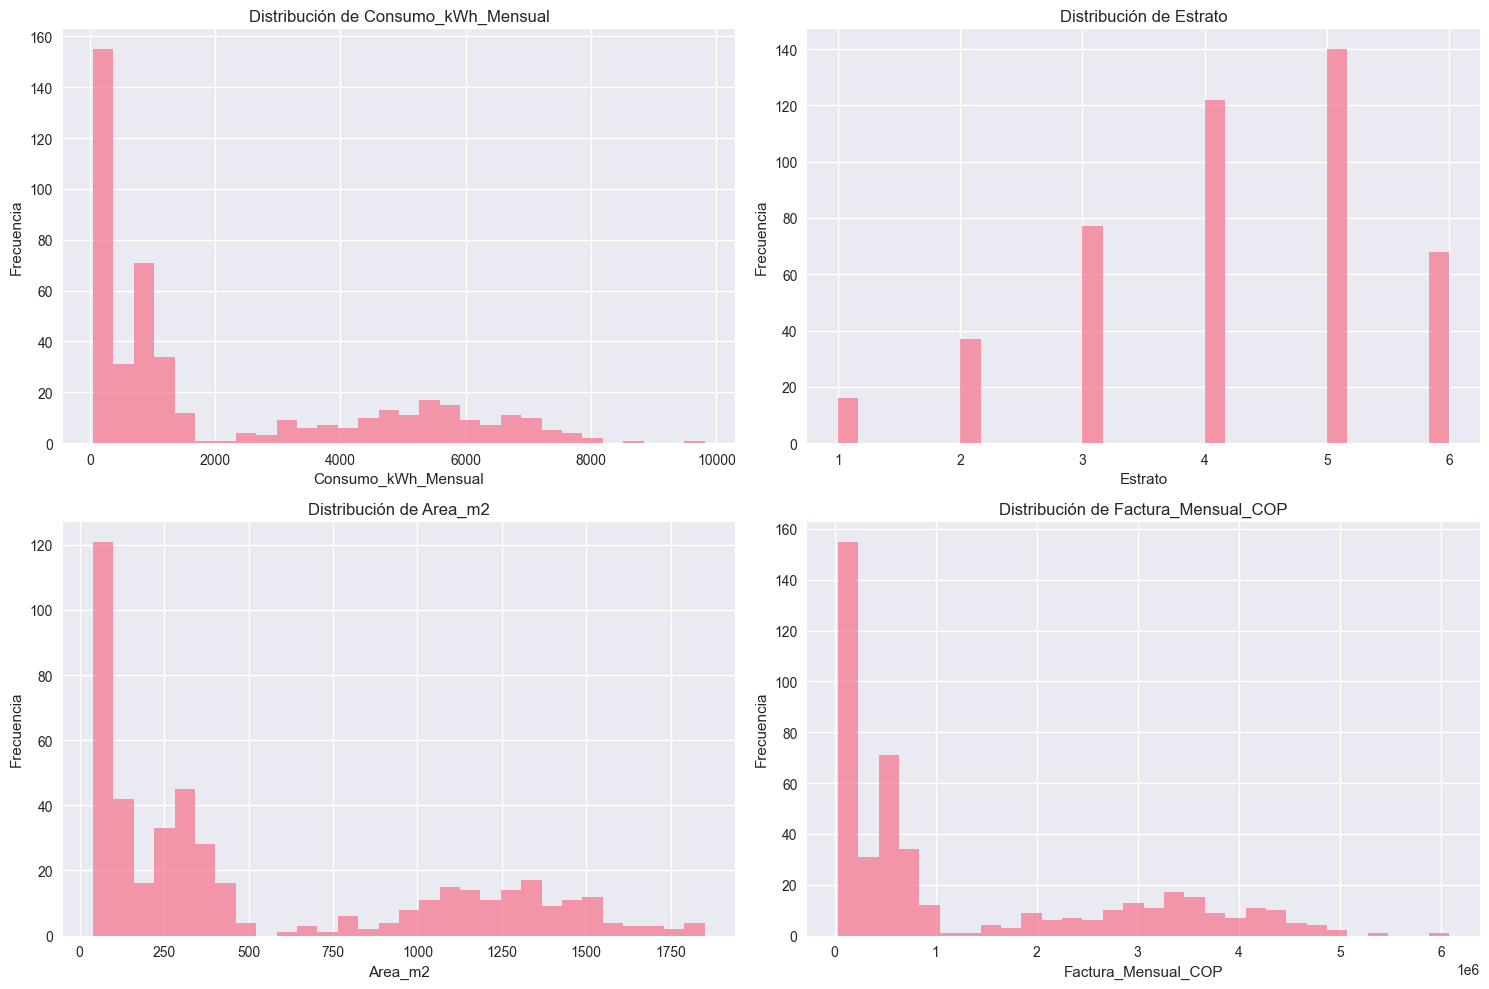

In [7]:
# ============================================================================
# VISUALIZACIÓN DE DISTRIBUCIONES DE VARIABLES NUMÉRICAS
# ============================================================================

# plt.subplots(): Crea una figura con múltiples subgráficos (subplots)
# Parámetros:
#   - 2, 2: Crea una grilla de 2 filas x 2 columnas (4 gráficos en total)
#   - figsize=(15, 10): Tamaño de la figura en pulgadas (ancho, alto)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# axes.ravel(): Convierte el array 2D de ejes en un array 1D
# Esto facilita iterar sobre los subgráficos uno por uno
axes = axes.ravel()

# Itera sobre las primeras 4 variables numéricas ([:4] limita a 4)
# enumerate(): Proporciona tanto el índice (i) como el valor (var)
for i, var in enumerate(numerical_vars[:4]):
    # df[var].hist(): Crea un histograma de la variable
    # Parámetros:
    #   - bins=30: Divide el rango de valores en 30 intervalos (barras)
    #   - ax=axes[i]: Especifica en qué subgráfico dibujar
    #   - alpha=0.7: Transparencia (0=invisible, 1=opaco)
    df[var].hist(bins=30, ax=axes[i], alpha=0.7)
    
    # Configura los títulos y etiquetas de cada subgráfico
    axes[i].set_title(f'Distribución de {var}')  # Título del gráfico
    axes[i].set_xlabel(var)                      # Etiqueta del eje X (nombre de la variable)
    axes[i].set_ylabel('Frecuencia')            # Etiqueta del eje Y (cantidad de registros)

# plt.tight_layout(): Ajusta automáticamente el espaciado entre subgráficos
# Evita que los títulos y etiquetas se superpongan
plt.tight_layout()

# plt.show(): Muestra el gráfico
plt.show()

# INTERPRETACIÓN DE HISTOGRAMAS:
# - Forma: ¿Es simétrica, sesgada a la izquierda/derecha, bimodal?
# - Centro: ¿Dónde está la mayoría de los valores?
# - Dispersión: ¿Los datos están concentrados o dispersos?
# - Outliers: ¿Hay valores muy alejados del resto?

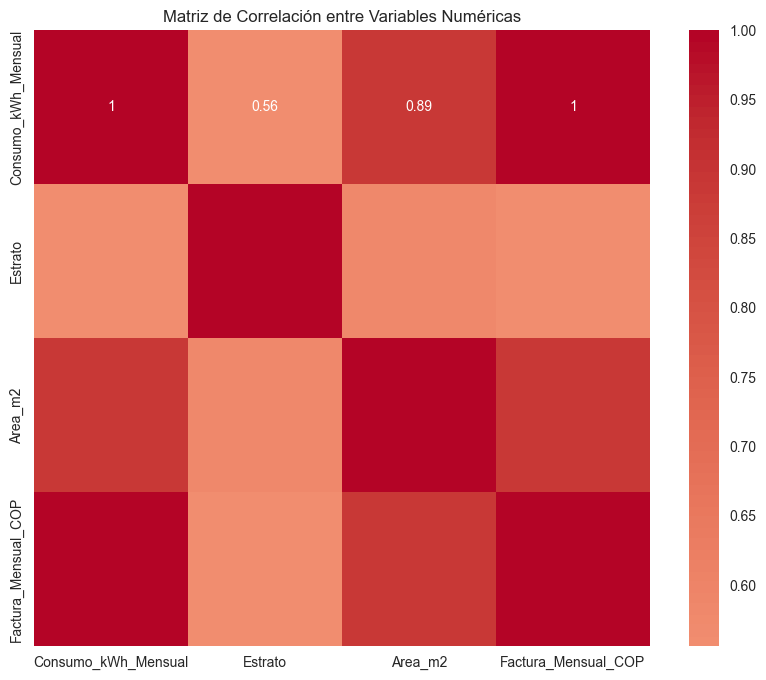

In [8]:
# ============================================================================
# MATRIZ DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS
# ============================================================================

# df[numerical_vars].corr(): Calcula la matriz de correlación de Pearson
# Correlación mide la relación lineal entre dos variables:
#   - Rango: -1 a +1
#   - +1: Correlación positiva perfecta (cuando una aumenta, la otra también)
#   - 0: No hay correlación lineal
#   - -1: Correlación negativa perfecta (cuando una aumenta, la otra disminuye)
#   - Valores cercanos a ±0.7 o más: Correlación fuerte
#   - Valores entre ±0.3 y ±0.7: Correlación moderada
#   - Valores menores a ±0.3: Correlación débil
correlation_matrix = df[numerical_vars].corr()

# plt.figure(): Crea una nueva figura para el gráfico
# figsize=(10, 8): Define el tamaño de la figura (ancho=10, alto=8 pulgadas)
plt.figure(figsize=(10, 8))

# sns.heatmap(): Crea un mapa de calor (heatmap) de la matriz de correlación
# Parámetros:
#   - correlation_matrix: La matriz de correlación a visualizar
#   - annot=True: Muestra los valores numéricos en cada celda
#   - cmap='coolwarm': Paleta de colores (azul=frio/negativo, rojo=caliente/positivo)
#   - center=0: El color neutro (blanco) está en el valor 0
#   - square=True: Hace las celdas cuadradas (mejor visualización)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)

# Configura el título del gráfico
plt.title('Matriz de Correlación entre Variables Numéricas')

# Muestra el gráfico
plt.show()

# INTERPRETACIÓN:
# - Valores altos (cercanos a 1 o -1): Variables fuertemente relacionadas
# - Si dos variables predictoras están muy correlacionadas (>0.8), puede causar
#   multicolinealidad en modelos lineales (se pueden eliminar una de ellas)
# - La diagonal siempre es 1.0 (correlación de una variable consigo misma)

## 3. Preprocesamiento de Datos

In [9]:
# ============================================================================
# PREPARACIÓN DE DATOS PARA MODELADO
# ============================================================================

# --- CREAR COPIA DEL DATASET ORIGINAL ---
# df.copy(): Crea una copia independiente del DataFrame
# Esto es importante para no modificar los datos originales
df_model = df.copy()

# --- ELIMINAR VARIABLES NO PREDICTORAS ---
# Estas columnas no deben usarse como variables predictoras porque:
#   - 'ID_Cliente': Es solo un identificador único, no aporta información predictiva
#   - 'Validar': Es una columna de control/validación, no es una característica
#   - 'Factura_Mensual_COP': Está altamente correlacionada con el consumo
#                            (la factura depende directamente del consumo)
#                            Usarla sería "hacer trampa" porque ya contiene la respuesta
features_to_drop = ['ID_Cliente', 'Validar', 'Factura_Mensual_COP']
df_model = df_model.drop(columns=features_to_drop)  # Elimina las columnas especificadas

# --- DEFINIR VARIABLE OBJETIVO (TARGET) ---
# La variable objetivo es lo que queremos predecir: el consumo energético mensual
target = 'Consumo_kWh_Mensual'

# y: Variable objetivo (lo que queremos predecir)
# Se extrae del DataFrame como una Serie de pandas
y = df_model[target]

# X: Variables predictoras (características que usaremos para predecir)
# Se obtiene eliminando la columna objetivo del DataFrame
X = df_model.drop(columns=[target])

# --- VERIFICAR LA PREPARACIÓN ---
# Imprime información sobre las variables preparadas para verificar que todo está correcto
print(f"Variables predictoras: {X.columns.tolist()}")
print(f"Variable objetivo: {target}")
print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")

# NOTA: X.shape muestra (número_de_filas, número_de_columnas)
#       y.shape muestra (número_de_filas,) porque es una Serie unidimensional

Variables predictoras: ['Sector', 'Estrato', 'Ciudad', 'Area_m2', 'Puede_Pagar_Solar']
Variable objetivo: Consumo_kWh_Mensual
Forma de X: (460, 5), Forma de y: (460,)


In [10]:
# ============================================================================
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# ============================================================================

# LabelEncoder: Convierte etiquetas categóricas (texto) a números
# Ejemplo: 'Residencial' → 0, 'Comercial' → 1, 'Industrial' → 2
# Esto es necesario porque los algoritmos de ML solo trabajan con números
le = LabelEncoder()

# Identifica qué columnas son categóricas (tipo 'object')
categorical_features = X.select_dtypes(include=['object']).columns

# Itera sobre cada columna categórica y la codifica
for col in categorical_features:
    # .astype(str): Convierte todos los valores a string (por si hay valores mixtos)
    # .fit_transform(): Aprende el mapeo y aplica la transformación en un solo paso
    #   - fit: Aprende qué número asignar a cada categoría única
    #   - transform: Aplica la conversión (texto → número)
    X[col] = le.fit_transform(X[col].astype(str))

# Verifica qué variables fueron codificadas
print("Variables categóricas codificadas:", categorical_features.tolist())

# Muestra cómo quedaron los datos después de la codificación
print("\nDatos después de codificación:")
print(X.head())

# NOTA IMPORTANTE:
# - Después de la codificación, todas las columnas son numéricas
# - Cada categoría única tiene un número asignado (0, 1, 2, ...)
# - Si necesitas hacer predicciones futuras, debes usar el mismo LabelEncoder
#   con el mismo mapeo (por eso se guarda el encoder junto con el modelo)

Variables categóricas codificadas: ['Sector', 'Ciudad', 'Puede_Pagar_Solar']

Datos después de codificación:
   Sector  Estrato  Ciudad     Area_m2  Puede_Pagar_Solar
0       2        4       3   77.234714                  0
1       2        1       4  122.833169                  0
2       2        4       3  100.210306                  0
3       2        2       1   69.496604                  0
4       2        3       1   71.444142                  0


In [11]:
# ============================================================================
# MANEJO DE VALORES NULOS (DATOS FALTANTES)
# ============================================================================

# --- VERIFICAR VALORES NULOS ANTES DEL TRATAMIENTO ---
# X.isnull().sum(): Cuenta cuántos valores nulos hay en cada columna de X
print("Valores nulos antes de imputación:")
print(X.isnull().sum())

# y.isnull().sum(): Cuenta valores nulos en la variable objetivo
print(f"Valores nulos en y: {y.isnull().sum()}")

# --- IMPUTACIÓN DE VALORES NULOS EN VARIABLES PREDICTORAS (X) ---
# SimpleImputer: Rellena valores faltantes usando una estrategia específica
# strategy='median': Usa la mediana (valor del medio) para rellenar nulos
#   - Ventaja: La mediana es robusta a outliers (no se ve afectada por valores extremos)
#   - Alternativas: 'mean' (promedio), 'most_frequent' (moda), 'constant' (valor fijo)
imputer = SimpleImputer(strategy='median')

# fit_transform(): 
#   - fit: Calcula la mediana de cada columna usando solo los datos de entrenamiento
#   - transform: Rellena los valores nulos con la mediana calculada
# pd.DataFrame(): Convierte el resultado (array numpy) de vuelta a DataFrame
#                 manteniendo los nombres de las columnas originales
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# --- ELIMINAR FILAS CON VALORES NULOS EN LA VARIABLE OBJETIVO (y) ---
# ~y.isnull(): Crea una máscara booleana (True donde NO hay nulos, False donde sí hay)
# El operador ~ invierte los valores booleanos
mask = ~y.isnull()

# Aplica la máscara para filtrar solo las filas donde y no es nulo
# Esto elimina las filas donde la variable objetivo está faltante
X_clean = X_imputed[mask]  # Solo filas donde y no es nulo
y_clean = y[mask]          # Solo valores no nulos de y

# --- VERIFICAR RESULTADO FINAL ---
print(f"\nDatos finales - X: {X_clean.shape}, y: {y_clean.shape}")
print(f"Valores nulos restantes en X: {X_clean.isnull().sum().sum()}")
print(f"Valores nulos restantes en y: {y_clean.isnull().sum()}")

# NOTA IMPORTANTE:
# - La imputación se hace SOLO en X (variables predictoras)
# - Para y (variable objetivo), se eliminan las filas con nulos
# - Esto es porque no podemos "inventar" el valor que queremos predecir
# - El imputer se guarda para usar el mismo mapeo en datos futuros

Valores nulos antes de imputación:
Sector               0
Estrato              0
Ciudad               0
Area_m2              0
Puede_Pagar_Solar    0
dtype: int64
Valores nulos en y: 4

Datos finales - X: (456, 5), y: (456,)
Valores nulos restantes en X: 0
Valores nulos restantes en y: 0


## 4. División de Datos (70/30)

In [12]:
# ============================================================================
# DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA (70% / 30%)
# ============================================================================

# train_test_split(): Divide el dataset en dos partes:
#   - Datos de ENTRENAMIENTO (70%): Se usan para entrenar el modelo
#   - Datos de PRUEBA (30%): Se usan para evaluar el modelo (nunca vistos durante el entrenamiento)
#
# Parámetros:
#   - X_clean: Variables predictoras (features)
#   - y_clean: Variable objetivo (target)
#   - test_size=0.3: 30% de los datos van a prueba (70% a entrenamiento)
#   - random_state=42: Semilla aleatoria para reproducibilidad (siempre misma división)
#   - stratify=None: No estratifica (útil para clasificación, no necesario en regresión)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42, stratify=None
)

# Verifica las dimensiones de los datos divididos
print(f"Datos de entrenamiento: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Datos de prueba: X_test: {X_test.shape}, y_test: {y_test.shape}")

# ============================================================================
# ESCALADO DE CARACTERÍSTICAS (ESTANDARIZACIÓN)
# ============================================================================

# StandardScaler: Estandariza las variables numéricas
# Transforma cada variable para que tenga:
#   - Media = 0
#   - Desviación estándar = 1
# Fórmula: (valor - media) / desviación_estándar
#
# ¿Por qué escalar?
# - Algunos algoritmos (Regresión Lineal, Ridge, Lasso) son sensibles a la escala
# - Variables con rangos muy diferentes pueden dominar el modelo
# - Ejemplo: Si 'Area_m2' va de 0-2000 y 'Estrato' va de 1-6, sin escalar
#            'Area_m2' tendría mucho más peso
scaler = StandardScaler()

# fit_transform(): Calcula la media y std del conjunto de entrenamiento y aplica la transformación
# IMPORTANTE: Solo se ajusta (fit) con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# transform(): Aplica la misma transformación a los datos de prueba
# IMPORTANTE: NO se hace fit de nuevo, se usa la media y std calculadas del entrenamiento
#            Esto evita "data leakage" (filtrar información del test al train)
X_test_scaled = scaler.transform(X_test)

print("\nDatos escalados correctamente")

# NOTA: Los modelos basados en árboles (Random Forest, Decision Tree, Gradient Boosting)
#       NO necesitan escalado porque trabajan con divisiones, no con distancias.
#       Por eso algunos modelos usan X_train_scaled y otros X_train sin escalar.

Datos de entrenamiento: X_train: (319, 5), y_train: (319,)
Datos de prueba: X_test: (137, 5), y_test: (137,)

Datos escalados correctamente


## 5. Modelos de Regresión

In [13]:
# ============================================================================
# CONFIGURACIÓN Y FUNCIÓN DE EVALUACIÓN DE MODELOS
# ============================================================================

# Diccionario para almacenar los resultados de todos los modelos evaluados
# Estructura: {'Nombre_Modelo': {métricas}, ...}
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Evalúa un modelo de machine learning y calcula múltiples métricas de rendimiento
    
    Parámetros:
    -----------
    name : str
        Nombre del modelo (para identificación)
    model : objeto del modelo
        Modelo de sklearn ya configurado (puede ser GridSearchCV o modelo simple)
    X_train, y_train : arrays
        Datos de entrenamiento (features y target)
    X_test, y_test : arrays
        Datos de prueba (features y target)
    
    Retorna:
    --------
    metrics : dict
        Diccionario con todas las métricas calculadas
    y_pred_test : array
        Predicciones del modelo en el conjunto de prueba
    """
    
    # --- ENTRENAR EL MODELO ---
    # model.fit(): Entrena el modelo con los datos de entrenamiento
    # Si es GridSearchCV, también busca los mejores hiperparámetros
    model.fit(X_train, y_train)
    
    # --- REALIZAR PREDICCIONES ---
    # model.predict(): Genera predicciones usando el modelo entrenado
    y_pred_train = model.predict(X_train)  # Predicciones en datos de entrenamiento
    y_pred_test = model.predict(X_test)    # Predicciones en datos de prueba (nunca vistos)
    
    # --- CALCULAR MÉTRICAS DE RENDIMIENTO ---
    # Las métricas se calculan tanto para train como para test para detectar overfitting
    metrics = {
        # R² Score (Coeficiente de determinación): Mide qué tan bien el modelo explica la varianza
        # Rango: -∞ a 1 (1 = perfecto, 0 = igual que predecir la media, negativo = peor que la media)
        'R2_train': r2_score(y_train, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test),
        
        # RMSE (Root Mean Squared Error): Error cuadrático medio en la escala original
        # Penaliza más los errores grandes. Misma unidad que la variable objetivo (kWh)
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        
        # MAE (Mean Absolute Error): Error absoluto medio
        # Promedio de los errores absolutos. Más robusto a outliers que RMSE
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test)
    }
    
    # --- VALIDACIÓN CRUZADA (CROSS-VALIDATION) ---
    # cross_val_score(): Divide los datos de entrenamiento en 5 partes (folds)
    #                   Entrena 5 veces, cada vez usando 4 partes para entrenar y 1 para validar
    #                   Esto da una estimación más robusta del rendimiento
    # cv=5: 5 divisiones (5-fold cross-validation)
    # scoring='r2': Usa R² como métrica de evaluación
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Agrega las métricas de validación cruzada al diccionario
    metrics['CV_R2_mean'] = cv_scores.mean()  # Promedio de los 5 R² scores
    metrics['CV_R2_std'] = cv_scores.std()    # Desviación estándar (mide la variabilidad)
    
    return metrics, y_pred_test

# NOTA: Esta función permite evaluar cualquier modelo de manera consistente
#       y comparar fácilmente el rendimiento entre diferentes algoritmos

### 5.1 Regresión Lineal

In [14]:
# ============================================================================
# ENTRENAMIENTO DEL MODELO: REGRESIÓN LINEAL SIMPLE
# ============================================================================

# LinearRegression: Modelo de regresión lineal más básico
# Ecuación: y = b0 + b1*x1 + b2*x2 + ... + bn*xn
# Donde:
#   - y: Variable objetivo (consumo energético)
#   - b0: Intercepto (valor cuando todas las variables son 0)
#   - b1, b2, ...: Coeficientes (peso de cada variable)
#   - x1, x2, ...: Variables predictoras
#
# Ventajas:
#   - Simple y fácil de interpretar
#   - Rápido de entrenar
#   - Los coeficientes muestran la importancia de cada variable
#
# Desventajas:
#   - Asume relación lineal (no captura relaciones no lineales)
#   - Sensible a outliers
#   - Requiere escalado de datos
lr = LinearRegression()

# Entrena y evalúa el modelo usando datos escalados (requerido para regresión lineal)
# X_train_scaled, X_test_scaled: Datos estandarizados (media=0, std=1)
lr_metrics, lr_pred = evaluate_model('Linear Regression', lr, X_train_scaled, X_test_scaled, y_train, y_test)

# Guarda los resultados para comparación posterior
results['Linear Regression'] = lr_metrics

# --- MOSTRAR RESULTADOS ---
print("=== REGRESIÓN LINEAL ===")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

# NOTA: Si quieres ver los coeficientes del modelo:
#   print(f"Coeficientes: {lr.coef_}")
#   print(f"Intercepto: {lr.intercept_}")

=== REGRESIÓN LINEAL ===
R2_train: 0.7867
R2_test: 0.8404
RMSE_train: 1097.2151
RMSE_test: 1009.4537
MAE_train: 700.1091
MAE_test: 675.0888
CV_R2_mean: 0.7775
CV_R2_std: 0.0418


### 5.2 Regresión Ridge

In [15]:
# ============================================================================
# ENTRENAMIENTO DEL MODELO: REGRESIÓN RIDGE
# ============================================================================

# Ridge Regression: Regresión lineal con regularización L2
# Similar a regresión lineal, pero añade un término de penalización
# que reduce el tamaño de los coeficientes para evitar overfitting
#
# Ecuación: Minimiza (Error) + alpha * (suma de coeficientes²)
# Donde alpha es el parámetro de regularización:
#   - alpha pequeño (0.1): Poca regularización, similar a regresión lineal
#   - alpha grande (1000): Mucha regularización, coeficientes muy pequeños
#
# Ventajas sobre regresión lineal:
#   - Reduce overfitting (sobreajuste)
#   - Maneja mejor la multicolinealidad (variables correlacionadas)
#   - Más estable con datos pequeños
#
# Desventajas:
#   - No elimina variables (todos los coeficientes son diferentes de 0)
#   - Requiere encontrar el alpha óptimo

# --- CONFIGURACIÓN DE HIPERPARÁMETROS ---
# alpha: Parámetro de regularización (lambda en la literatura)
# Valores más altos = más regularización = coeficientes más pequeños
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}

# GridSearchCV: Prueba todas las combinaciones de alpha para encontrar el mejor
ridge = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')

# Entrena y evalúa el modelo (usa datos escalados)
ridge_metrics, ridge_pred = evaluate_model('Ridge', ridge, X_train_scaled, X_test_scaled, y_train, y_test)
results['Ridge'] = ridge_metrics

# --- MOSTRAR RESULTADOS ---
print("=== REGRESIÓN RIDGE ===")
# best_params_: Muestra el valor de alpha que dio el mejor rendimiento
print(f"Mejor alpha: {ridge.best_params_['alpha']}")
for metric, value in ridge_metrics.items():
    print(f"{metric}: {value:.4f}")

=== REGRESIÓN RIDGE ===
Mejor alpha: 1.0
R2_train: 0.7867
R2_test: 0.8405
RMSE_train: 1097.2352
RMSE_test: 1009.0338
MAE_train: 700.3184
MAE_test: 675.6020
CV_R2_mean: 0.7766
CV_R2_std: 0.0392


### 5.3 Regresión Lasso

In [16]:
# ============================================================================
# ENTRENAMIENTO DEL MODELO: REGRESIÓN LASSO
# ============================================================================

# Lasso Regression: Regresión lineal con regularización L1
# Similar a Ridge, pero usa la suma del valor absoluto de los coeficientes
# en lugar de la suma de los cuadrados
#
# Ecuación: Minimiza (Error) + alpha * (suma de |coeficientes|)
#
# DIFERENCIA CLAVE con Ridge:
#   - Lasso puede hacer coeficientes EXACTAMENTE cero (elimina variables)
#   - Ridge solo reduce el tamaño de los coeficientes (no los elimina)
#   - Lasso es útil para selección de características (feature selection)
#
# Ventajas:
#   - Selección automática de características (elimina variables irrelevantes)
#   - Reduce overfitting
#   - Modelo más simple y fácil de interpretar
#
# Desventajas:
#   - Puede eliminar variables importantes si están correlacionadas
#   - Menos estable que Ridge con datos pequeños

# --- CONFIGURACIÓN DE HIPERPARÁMETROS ---
# alpha: Parámetro de regularización
# Nota: Lasso típicamente usa valores de alpha más pequeños que Ridge
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

# GridSearchCV: Busca el mejor valor de alpha
lasso = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='r2')

# Entrena y evalúa el modelo (usa datos escalados)
lasso_metrics, lasso_pred = evaluate_model('Lasso', lasso, X_train_scaled, X_test_scaled, y_train, y_test)
results['Lasso'] = lasso_metrics

# --- MOSTRAR RESULTADOS ---
print("=== REGRESIÓN LASSO ===")
print(f"Mejor alpha: {lasso.best_params_['alpha']}")
for metric, value in lasso_metrics.items():
    print(f"{metric}: {value:.4f}")

# --- ANÁLISIS DE SELECCIÓN DE CARACTERÍSTICAS ---
# Lasso puede hacer que algunos coeficientes sean exactamente cero
# Esto significa que esas variables fueron "eliminadas" del modelo
lasso_coef = lasso.best_estimator_.coef_  # Obtiene los coeficientes del mejor modelo

# Filtra las características con coeficiente significativo (> 0.001 en valor absoluto)
# Si el coeficiente es muy cercano a 0, la variable fue prácticamente eliminada
selected_features = [X_clean.columns[i] for i in range(len(lasso_coef)) if abs(lasso_coef[i]) > 0.001]
print(f"\nCaracterísticas seleccionadas por Lasso: {selected_features}")

# NOTA: Si todas las características aparecen en la lista, significa que Lasso
#       no eliminó ninguna variable (todas son importantes para el modelo)

=== REGRESIÓN LASSO ===
Mejor alpha: 10.0
R2_train: 0.7865
R2_test: 0.8407
RMSE_train: 1097.7700
RMSE_test: 1008.6035
MAE_train: 696.2569
MAE_test: 670.6168
CV_R2_mean: 0.7778
CV_R2_std: 0.0427

Características seleccionadas por Lasso: ['Sector', 'Estrato', 'Ciudad', 'Area_m2', 'Puede_Pagar_Solar']


### 5.4 Regresión ElasticNet

In [17]:
# ============================================================================
# ENTRENAMIENTO DEL MODELO: REGRESIÓN ELASTICNET
# ============================================================================

# ElasticNet Regression: Combina regularización L1 (Lasso) y L2 (Ridge)
# Es un compromiso entre Lasso y Ridge, combinando lo mejor de ambos
#
# Ecuación: Minimiza (Error) + alpha * [l1_ratio * L1 + (1-l1_ratio) * L2]
#
# Parámetros:
#   - alpha: Fuerza de la regularización (igual que en Ridge/Lasso)
#   - l1_ratio: Proporción de regularización L1 vs L2
#     * l1_ratio = 1.0 → Es Lasso puro (solo L1)
#     * l1_ratio = 0.0 → Es Ridge puro (solo L2)
#     * l1_ratio = 0.5 → 50% L1, 50% L2 (balance)
#
# Ventajas:
#   - Combina ventajas de Lasso (selección de características) y Ridge (estabilidad)
#   - Mejor que Lasso cuando hay muchas variables correlacionadas
#   - Más flexible que Ridge o Lasso solos
#
# Desventajas:
#   - Tiene dos hiperparámetros que optimizar (más lento)
#   - Más complejo de interpretar

# --- CONFIGURACIÓN DE HIPERPARÁMETROS ---
# GridSearchCV probará todas las combinaciones de alpha y l1_ratio
elastic_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0],        # Fuerza de regularización
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]       # Proporción L1/L2 (0.1=10% L1, 90% L2)
}

# GridSearchCV: Busca la mejor combinación de alpha y l1_ratio
# Esto probará 4 * 4 = 16 combinaciones diferentes
elastic = GridSearchCV(ElasticNet(), elastic_params, cv=5, scoring='r2')

# Entrena y evalúa el modelo (usa datos escalados)
elastic_metrics, elastic_pred = evaluate_model('ElasticNet', elastic, X_train_scaled, X_test_scaled, y_train, y_test)
results['ElasticNet'] = elastic_metrics

# --- MOSTRAR RESULTADOS ---
print("=== REGRESIÓN ELASTICNET ===")
# best_params_: Muestra los valores óptimos de alpha y l1_ratio
print(f"Mejores parámetros: {elastic.best_params_}")
for metric, value in elastic_metrics.items():
    print(f"{metric}: {value:.4f}")

=== REGRESIÓN ELASTICNET ===
Mejores parámetros: {'alpha': 0.1, 'l1_ratio': 0.9}
R2_train: 0.7866
R2_test: 0.8408
RMSE_train: 1097.4175
RMSE_test: 1008.2887
MAE_train: 700.9094
MAE_test: 676.8412
CV_R2_mean: 0.7769
CV_R2_std: 0.0388


### 5.5 Decision Tree

In [18]:
# ============================================================================
# ENTRENAMIENTO DEL MODELO: ÁRBOL DE DECISIÓN (DECISION TREE)
# ============================================================================

# Decision Tree: Algoritmo que divide los datos en regiones usando reglas simples
# Funciona como un árbol: cada nodo hace una pregunta (ej: "¿Area_m2 > 500?")
# y divide los datos en dos ramas según la respuesta
#
# Cómo funciona:
#   1. Encuentra la mejor variable y valor para dividir los datos
#   2. Divide los datos en dos grupos
#   3. Repite el proceso en cada grupo hasta alcanzar un criterio de parada
#   4. Cada hoja final predice el promedio de los valores en esa región
#
# Ventajas:
#   - Fácil de interpretar (puedes ver las reglas de decisión)
#   - No requiere escalado de datos
#   - Captura relaciones no lineales
#   - Maneja bien variables categóricas
#
# Desventajas:
#   - Propenso a overfitting (sobreajuste) si no se controla la profundidad
#   - Inestable (pequeños cambios en datos pueden cambiar mucho el árbol)
#   - Puede crear árboles muy complejos

# --- CONFIGURACIÓN DE HIPERPARÁMETROS ---
# Estos parámetros controlan la complejidad del árbol para evitar overfitting
dt_params = {
    'max_depth': [3, 5, 7, 10, None],      # Profundidad máxima del árbol
                                          # None = sin límite (puede sobreajustar)
                                          # Valores pequeños = árbol más simple
    'min_samples_split': [2, 5, 10],      # Mínimo de muestras para dividir un nodo
                                          # Valores altos = menos divisiones = árbol más simple
    'min_samples_leaf': [1, 2, 4]         # Mínimo de muestras en una hoja final
                                          # Valores altos = hojas más grandes = árbol más simple
}

# GridSearchCV: Busca la mejor combinación de hiperparámetros
# random_state=42: Semilla aleatoria para reproducibilidad
dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='r2')

# NOTA: Decision Tree NO requiere escalado, usa X_train y X_test sin escalar
dt_metrics, dt_pred = evaluate_model('Decision Tree', dt, X_train, X_test, y_train, y_test)
results['Decision Tree'] = dt_metrics

# --- MOSTRAR RESULTADOS ---
print("=== DECISION TREE ===")
print(f"Mejores parámetros: {dt.best_params_}")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value:.4f}")

# NOTA: Para visualizar el árbol:
#   from sklearn.tree import plot_tree
#   plot_tree(dt.best_estimator_, feature_names=X_clean.columns, filled=True)

=== DECISION TREE ===
Mejores parámetros: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
R2_train: 0.8656
R2_test: 0.8448
RMSE_train: 871.0876
RMSE_test: 995.3994
MAE_train: 493.2712
MAE_test: 581.4119
CV_R2_mean: 0.8129
CV_R2_std: 0.0930


### 5.6 Random Forest

In [19]:
# ============================================================================
# ENTRENAMIENTO DEL MODELO: RANDOM FOREST
# ============================================================================

# Random Forest: Algoritmo de ensamble que combina múltiples árboles de decisión
# Ventajas:
#   - Reduce el overfitting comparado con un solo árbol
#   - Puede capturar relaciones no lineales
#   - Proporciona importancia de características
#   - No requiere escalado de datos

# --- CONFIGURACIÓN DE HIPERPARÁMETROS PARA OPTIMIZAR ---
# GridSearchCV probará todas las combinaciones de estos valores
rf_params = {
    'n_estimators': [50, 100, 200],      # Número de árboles en el bosque (más = mejor pero más lento)
    'max_depth': [3, 5, 7, None],        # Profundidad máxima de cada árbol (None = sin límite)
    'min_samples_split': [2, 5, 10]      # Mínimo de muestras para dividir un nodo (previene overfitting)
}

# GridSearchCV: Busca los mejores hiperparámetros probando todas las combinaciones
# Parámetros:
#   - RandomForestRegressor(random_state=42): Modelo base con semilla aleatoria
#   - rf_params: Diccionario con los valores a probar
#   - cv=5: Validación cruzada de 5 folds (divide datos en 5 partes)
#   - scoring='r2': Usa R² como métrica para elegir el mejor modelo
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2')

# Entrena y evalúa el modelo usando la función personalizada
rf_metrics, rf_pred = evaluate_model('Random Forest', rf, X_train, X_test, y_train, y_test)

# Guarda los resultados en el diccionario para comparación posterior
results['Random Forest'] = rf_metrics

# --- MOSTRAR RESULTADOS ---
print("=== RANDOM FOREST ===")
# best_params_: Muestra los hiperparámetros que dieron el mejor rendimiento
print(f"Mejores parámetros: {rf.best_params_}")

# Imprime todas las métricas calculadas
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

# --- ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS ---
# feature_importances_: Mide qué tan importante es cada variable para hacer predicciones
# Valores más altos = la variable es más importante para el modelo
feature_importance = pd.DataFrame({
    'feature': X_clean.columns,                              # Nombres de las variables
    'importance': rf.best_estimator_.feature_importances_    # Importancia de cada variable
}).sort_values('importance', ascending=False)  # Ordena de mayor a menor importancia

print("\nImportancia de características:")
print(feature_importance)

# INTERPRETACIÓN:
# - La suma de todas las importancias = 1.0 (100%)
# - Si una variable tiene importancia 0.975, significa que explica el 97.5% de la predicción
# - Variables con importancia muy baja (< 0.01) podrían eliminarse para simplificar el modelo

=== RANDOM FOREST ===
Mejores parámetros: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
R2_train: 0.8684
R2_test: 0.8530
RMSE_train: 861.8183
RMSE_test: 968.7818
MAE_train: 483.0233
MAE_test: 559.0940
CV_R2_mean: 0.8244
CV_R2_std: 0.0804

Importancia de características:
             feature  importance
3            Area_m2    0.975060
0             Sector    0.018119
2             Ciudad    0.004466
1            Estrato    0.001910
4  Puede_Pagar_Solar    0.000445


### 5.7 Gradient Boosting

In [20]:
# ============================================================================
# ENTRENAMIENTO DEL MODELO: GRADIENT BOOSTING
# ============================================================================

# Gradient Boosting: Algoritmo de ensamble que combina múltiples árboles débiles
# Funciona de manera secuencial: cada nuevo árbol corrige los errores del anterior
#
# Cómo funciona:
#   1. Entrena un árbol simple
#   2. Calcula los errores (residuos) de ese árbol
#   3. Entrena un nuevo árbol para predecir esos errores
#   4. Combina ambos árboles (predicción original + corrección de errores)
#   5. Repite el proceso n_estimators veces
#
# Ventajas:
#   - Muy potente, puede lograr excelente rendimiento
#   - Captura relaciones complejas y no lineales
#   - No requiere escalado de datos
#   - Puede manejar diferentes tipos de variables
#
# Desventajas:
#   - Más lento de entrenar que Random Forest
#   - Más propenso a overfitting si no se ajustan bien los hiperparámetros
#   - Menos interpretable que un solo árbol
#   - Sensible a outliers

# --- CONFIGURACIÓN DE HIPERPARÁMETROS ---
gb_params = {
    'n_estimators': [50, 100, 150],      # Número de árboles a combinar
                                         # Más árboles = mejor pero más lento
    'learning_rate': [0.01, 0.1, 0.2],   # Tasa de aprendizaje (qué tan fuerte cada corrección)
                                         # Valores pequeños (0.01) = correcciones suaves, más árboles necesarios
                                         # Valores grandes (0.2) = correcciones fuertes, menos árboles
                                         # Típicamente: learning_rate bajo + n_estimators alto = mejor
    'max_depth': [3, 4, 5]               # Profundidad de cada árbol
                                         # Árboles más profundos = más complejos = riesgo de overfitting
}

# GridSearchCV: Busca la mejor combinación de hiperparámetros
# Esto probará 3 * 3 * 3 = 27 combinaciones diferentes
gb = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, scoring='r2')

# NOTA: Gradient Boosting NO requiere escalado, usa X_train y X_test sin escalar
gb_metrics, gb_pred = evaluate_model('Gradient Boosting', gb, X_train, X_test, y_train, y_test)
results['Gradient Boosting'] = gb_metrics

# --- MOSTRAR RESULTADOS ---
print("=== GRADIENT BOOSTING ===")
print(f"Mejores parámetros: {gb.best_params_}")
for metric, value in gb_metrics.items():
    print(f"{metric}: {value:.4f}")

# NOTA: Gradient Boosting puede tener muy buen R² en entrenamiento pero
#       peor en prueba si hay overfitting. Compara R2_train vs R2_test.

=== GRADIENT BOOSTING ===
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
R2_train: 0.9134
R2_test: 0.8196
RMSE_train: 699.0887
RMSE_test: 1073.0718
MAE_train: 411.3240
MAE_test: 634.8381
CV_R2_mean: 0.7793
CV_R2_std: 0.0514


## 6. Comparación de Modelos

In [21]:
# ============================================================================
# COMPARACIÓN Y RANKING DE TODOS LOS MODELOS
# ============================================================================

# --- CREAR DATAFRAME CON RESULTADOS ---
# pd.DataFrame(results): Convierte el diccionario de resultados en un DataFrame
# .T: Transpone el DataFrame (intercambia filas y columnas)
#     Esto hace que cada modelo sea una fila y cada métrica sea una columna
results_df = pd.DataFrame(results).T

# .round(4): Redondea todos los valores a 4 decimales para mejor legibilidad
results_df = results_df.round(4)

# --- MOSTRAR COMPARACIÓN COMPLETA ---
print("=== COMPARACIÓN DE MODELOS ===")
# Muestra todas las métricas para todos los modelos
print(results_df)

# --- ORDENAR MODELOS POR RENDIMIENTO ---
# sort_values('R2_test', ascending=False): Ordena los modelos por R² de test
#                                           de mayor a menor (el mejor primero)
# R² de test es la métrica principal porque mide el rendimiento en datos no vistos
results_sorted = results_df.sort_values('R2_test', ascending=False)

# --- MOSTRAR RANKING CON MÉTRICAS PRINCIPALES ---
print("\n=== RANKING POR R2 DE TEST ===")
# Selecciona solo las métricas más importantes para el ranking:
#   - R2_test: Coeficiente de determinación en datos de prueba (métrica principal)
#   - RMSE_test: Error cuadrático medio (en unidades originales: kWh)
#   - MAE_test: Error absoluto medio (en unidades originales: kWh)
#   - CV_R2_mean: R² promedio de validación cruzada (mide robustez del modelo)
print(results_sorted[['R2_test', 'RMSE_test', 'MAE_test', 'CV_R2_mean']])

# INTERPRETACIÓN DEL RANKING:
# - El modelo con mayor R2_test es generalmente el mejor
# - RMSE y MAE más bajos indican mejor rendimiento
# - CV_R2_mean alto indica que el modelo es robusto (buen rendimiento consistente)
# - Si R2_train >> R2_test, el modelo puede estar sobreajustado (overfitting)

=== COMPARACIÓN DE MODELOS ===
                   R2_train  R2_test  RMSE_train  RMSE_test  MAE_train  \
Linear Regression    0.7867   0.8404   1097.2151  1009.4537   700.1091   
Ridge                0.7867   0.8405   1097.2352  1009.0338   700.3184   
Lasso                0.7865   0.8407   1097.7700  1008.6035   696.2569   
ElasticNet           0.7866   0.8408   1097.4175  1008.2887   700.9094   
Decision Tree        0.8656   0.8448    871.0876   995.3994   493.2712   
Random Forest        0.8684   0.8530    861.8183   968.7818   483.0233   
Gradient Boosting    0.9134   0.8196    699.0887  1073.0718   411.3240   

                   MAE_test  CV_R2_mean  CV_R2_std  
Linear Regression  675.0888      0.7775     0.0418  
Ridge              675.6020      0.7766     0.0392  
Lasso              670.6168      0.7778     0.0427  
ElasticNet         676.8412      0.7769     0.0388  
Decision Tree      581.4119      0.8129     0.0930  
Random Forest      559.0940      0.8244     0.0804  
Gradi

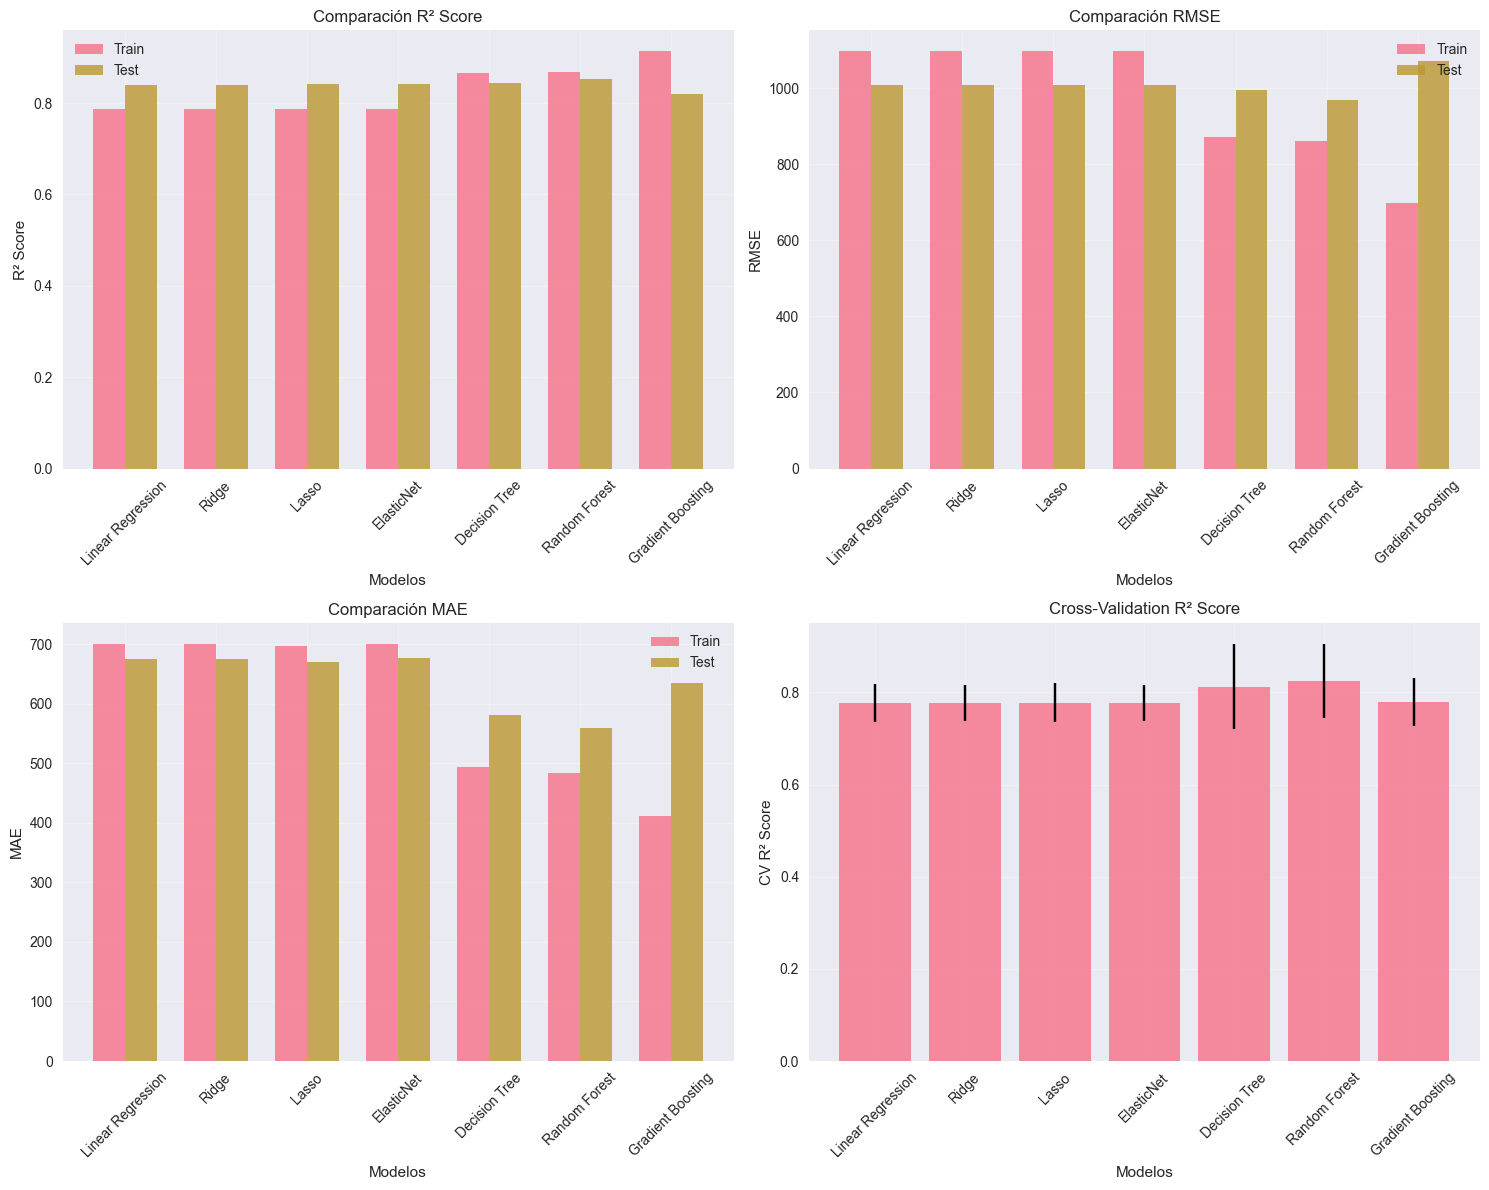

In [22]:
# ============================================================================
# VISUALIZACIÓN DE COMPARACIÓN DE MODELOS
# ============================================================================

# Crea una figura con 4 subgráficos (2 filas x 2 columnas) para comparar métricas
# figsize=(15, 12): Tamaño de la figura (ancho=15, alto=12 pulgadas)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# --- PREPARAR DATOS PARA GRÁFICOS ---
# Obtiene la lista de nombres de modelos del diccionario 'results'
models = list(results.keys())

# Extrae los valores de R² para entrenamiento y prueba de cada modelo
# List comprehension: Crea una lista con el valor de 'R2_train' de cada modelo
r2_train = [results[model]['R2_train'] for model in models]
r2_test = [results[model]['R2_test'] for model in models]

# np.arange(len(models)): Crea un array con posiciones [0, 1, 2, ...] para cada modelo
# Esto se usa para posicionar las barras en el gráfico
x = np.arange(len(models))

# width: Ancho de las barras (0.35 = 35% del espacio entre modelos)
# Se usa para crear barras lado a lado para Train y Test
width = 0.35

# ============ GRÁFICO 1: COMPARACIÓN R² SCORE (Train vs Test) ============
# axes[0,0]: Primer subgráfico (fila 0, columna 0)
# .bar(): Crea un gráfico de barras
#   - x - width/2: Posición de las barras de Train (desplazadas a la izquierda)
#   - x + width/2: Posición de las barras de Test (desplazadas a la derecha)
#   - width: Ancho de cada barra
#   - label: Etiqueta para la leyenda
#   - alpha=0.8: Transparencia (0.8 = 80% opaco)
axes[0,0].bar(x - width/2, r2_train, width, label='Train', alpha=0.8)
axes[0,0].bar(x + width/2, r2_test, width, label='Test', alpha=0.8)

# Configuración del gráfico
axes[0,0].set_xlabel('Modelos')                    # Etiqueta del eje X
axes[0,0].set_ylabel('R² Score')                   # Etiqueta del eje Y
axes[0,0].set_title('Comparación R² Score')        # Título del gráfico
axes[0,0].set_xticks(x)                            # Posiciones de las etiquetas en X
axes[0,0].set_xticklabels(models, rotation=45)     # Nombres de modelos (rotados 45°)
axes[0,0].legend()                                 # Muestra la leyenda (Train/Test)
axes[0,0].grid(True, alpha=0.3)                    # Activa la grilla (30% opacidad)

# INTERPRETACIÓN: Compara R² entre entrenamiento y prueba
# Si R²_train >> R²_test, el modelo está sobreajustado (overfitting)

# ============ GRÁFICO 2: COMPARACIÓN RMSE (Train vs Test) ============
# Extrae los valores de RMSE para cada modelo
rmse_train = [results[model]['RMSE_train'] for model in models]
rmse_test = [results[model]['RMSE_test'] for model in models]

# Crea barras comparativas de RMSE
axes[0,1].bar(x - width/2, rmse_train, width, label='Train', alpha=0.8)
axes[0,1].bar(x + width/2, rmse_test, width, label='Test', alpha=0.8)
axes[0,1].set_xlabel('Modelos')
axes[0,1].set_ylabel('RMSE')
axes[0,1].set_title('Comparación RMSE')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(models, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# INTERPRETACIÓN: RMSE más bajo = mejor modelo
# RMSE está en unidades originales (kWh), por lo que es fácil de interpretar

# ============ GRÁFICO 3: COMPARACIÓN MAE (Train vs Test) ============
# Extrae los valores de MAE para cada modelo
mae_train = [results[model]['MAE_train'] for model in models]
mae_test = [results[model]['MAE_test'] for model in models]

# Crea barras comparativas de MAE
axes[1,0].bar(x - width/2, mae_train, width, label='Train', alpha=0.8)
axes[1,0].bar(x + width/2, mae_test, width, label='Test', alpha=0.8)
axes[1,0].set_xlabel('Modelos')
axes[1,0].set_ylabel('MAE')
axes[1,0].set_title('Comparación MAE')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# INTERPRETACIÓN: MAE más bajo = mejor modelo
# MAE es más robusto a outliers que RMSE

# ============ GRÁFICO 4: CROSS-VALIDATION R² SCORE ============
# Extrae el promedio y desviación estándar de R² de validación cruzada
cv_r2_mean = [results[model]['CV_R2_mean'] for model in models]
cv_r2_std = [results[model]['CV_R2_std'] for model in models]

# .bar() con yerr: Crea barras con barras de error
#   - yerr=cv_r2_std: Muestra la desviación estándar como barra de error
#   - capsize=5: Tamaño de las "tapas" en las barras de error
axes[1,1].bar(x, cv_r2_mean, yerr=cv_r2_std, capsize=5, alpha=0.8)
axes[1,1].set_xlabel('Modelos')
axes[1,1].set_ylabel('CV R² Score')
axes[1,1].set_title('Cross-Validation R² Score')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models, rotation=45)
axes[1,1].grid(True, alpha=0.3)

# INTERPRETACIÓN: 
# - CV R² alto = modelo robusto (buen rendimiento consistente)
# - Barras de error pequeñas = modelo estable (poca variabilidad entre folds)

# --- AJUSTAR Y MOSTRAR GRÁFICOS ---
# tight_layout(): Ajusta automáticamente el espaciado entre subgráficos
plt.tight_layout()

# show(): Muestra todos los gráficos
plt.show()

# NOTA: Estos gráficos permiten comparar visualmente el rendimiento de todos los modelos
#       y identificar cuál tiene el mejor balance entre rendimiento y generalización

In [23]:
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Crear reporte Excel automatizado
def generar_reporte_excel(best_model_name=None, best_predictions=None, results_sorted=None,
                         y_test=None, X_train=None, X_test=None, df=None, X_clean=None):
    """Genera un reporte completo en Excel con todos los resultados del análisis"""

    # Nombre del archivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'Reporte_Consumo_ML_{timestamp}.xlsx'

    # Crear workbook
    wb = Workbook()

    # Estilos
    header_fill = PatternFill(start_color="4CAF50", end_color="4CAF50", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF", size=12)
    title_font = Font(bold=True, size=14, color="1F4788")
    border = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )

    # ============ HOJA 1: RESUMEN EJECUTIVO ============
    ws1 = wb.active
    ws1.title = "Resumen Ejecutivo"

    # Título
    ws1['A1'] = 'REPORTE DE PREDICCIÓN DE CONSUMO ENERGÉTICO - MACHINE LEARNING'
    ws1['A1'].font = Font(bold=True, size=16, color="1F4788")
    ws1.merge_cells('A1:D1')

    ws1['A2'] = f'Fecha de generación: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
    ws1['A2'].font = Font(italic=True)
    ws1.merge_cells('A2:D2')

    # Información del dataset
    row = 4
    ws1[f'A{row}'] = 'INFORMACIÓN DEL DATASET'
    ws1[f'A{row}'].font = title_font
    row += 1

    dataset_info = [
        ['Total de registros:', df.shape[0]],
        ['Registros válidos para modelado:', X_clean.shape[0]],
        ['Variables predictoras:', X_clean.shape[1]],
        ['División entrenamiento:', f'{X_train.shape[0]} ({X_train.shape[0]/X_clean.shape[0]*100:.1f}%)'],
        ['División prueba:', f'{X_test.shape[0]} ({X_test.shape[0]/X_clean.shape[0]*100:.1f}%)'],
    ]

    for item in dataset_info:
        ws1[f'A{row}'] = item[0]
        ws1[f'B{row}'] = item[1]
        ws1[f'A{row}'].font = Font(bold=True)
        row += 1

    # Mejor modelo
    row += 2
    ws1[f'A{row}'] = 'MEJOR MODELO SELECCIONADO'
    ws1[f'A{row}'].font = title_font
    row += 1

    ws1[f'A{row}'] = 'Modelo:'
    ws1[f'B{row}'] = best_model_name
    ws1[f'A{row}'].font = Font(bold=True)
    ws1[f'B{row}'].font = Font(bold=True, size=12, color="006400")
    row += 1

    best_model_info = [
        ['R² Score (Test):', f"{results_sorted.loc[best_model_name, 'R2_test']:.4f}"],
        ['RMSE (Test):', f"{results_sorted.loc[best_model_name, 'RMSE_test']:.2f}"],
        ['MAE (Test):', f"{results_sorted.loc[best_model_name, 'MAE_test']:.2f}"],
        ['CV R² Media:', f"{results_sorted.loc[best_model_name, 'CV_R2_mean']:.4f}"],
        ['CV R² Std:', f"{results_sorted.loc[best_model_name, 'CV_R2_std']:.4f}"],
    ]

    for item in best_model_info:
        ws1[f'A{row}'] = item[0]
        ws1[f'B{row}'] = item[1]
        ws1[f'A{row}'].font = Font(bold=True)
        row += 1

    # Top 3 modelos
    row += 2
    ws1[f'A{row}'] = 'TOP 3 MODELOS'
    ws1[f'A{row}'].font = title_font
    row += 1

    # Encabezados
    headers = ['Ranking', 'Modelo', 'R² Test', 'RMSE Test', 'MAE Test']
    for col, header in enumerate(headers, start=1):
        cell = ws1.cell(row=row, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border
    row += 1

    # Datos top 3
    for i, (model_name, metrics) in enumerate(results_sorted.head(3).iterrows(), start=1):
        ws1[f'A{row}'] = i
        ws1[f'B{row}'] = model_name
        ws1[f'C{row}'] = f"{metrics['R2_test']:.4f}"
        ws1[f'D{row}'] = f"{metrics['RMSE_test']:.2f}"
        ws1[f'E{row}'] = f"{metrics['MAE_test']:.2f}"

        for col in range(1, 6):
            ws1.cell(row=row, column=col).border = border
            ws1.cell(row=row, column=col).alignment = Alignment(horizontal='center')
        row += 1

    # Ajustar anchos
    ws1.column_dimensions['A'].width = 25
    ws1.column_dimensions['B'].width = 20
    ws1.column_dimensions['C'].width = 15
    ws1.column_dimensions['D'].width = 15
    ws1.column_dimensions['E'].width = 15

    # ============ HOJA 2: COMPARACIÓN DE MODELOS ============
    ws2 = wb.create_sheet("Comparación Modelos")

    ws2['A1'] = 'COMPARACIÓN DETALLADA DE MODELOS'
    ws2['A1'].font = title_font
    ws2.merge_cells('A1:I1')

    # Encabezados
    headers = ['Modelo', 'R² Train', 'R² Test', 'RMSE Train', 'RMSE Test',
               'MAE Train', 'MAE Test', 'CV R² Mean', 'CV R² Std']
    for col, header in enumerate(headers, start=1):
        cell = ws2.cell(row=3, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border

    # Datos
    row = 4
    for model_name, metrics in results_sorted.iterrows():
        ws2[f'A{row}'] = model_name
        ws2[f'B{row}'] = f"{metrics['R2_train']:.4f}"
        ws2[f'C{row}'] = f"{metrics['R2_test']:.4f}"
        ws2[f'D{row}'] = f"{metrics['RMSE_train']:.2f}"
        ws2[f'E{row}'] = f"{metrics['RMSE_test']:.2f}"
        ws2[f'F{row}'] = f"{metrics['MAE_train']:.2f}"
        ws2[f'G{row}'] = f"{metrics['MAE_test']:.2f}"
        ws2[f'H{row}'] = f"{metrics['CV_R2_mean']:.4f}"
        ws2[f'I{row}'] = f"{metrics['CV_R2_std']:.4f}"

        # Resaltar mejor modelo
        if model_name == best_model_name:
            for col in range(1, 10):
                ws2.cell(row=row, column=col).fill = PatternFill(
                    start_color="C6EFCE", end_color="C6EFCE", fill_type="solid"
                )

        for col in range(1, 10):
            ws2.cell(row=row, column=col).border = border
            ws2.cell(row=row, column=col).alignment = Alignment(horizontal='center')
        row += 1

    # Ajustar anchos
    for col in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
        ws2.column_dimensions[col].width = 15

    # ============ HOJA 3: PREDICCIONES Y ERRORES ============
    ws3 = wb.create_sheet("Predicciones")

    ws3['A1'] = 'PREDICCIONES DEL MEJOR MODELO'
    ws3['A1'].font = title_font
    ws3.merge_cells('A1:F1')

    ws3['A2'] = f'Modelo: {best_model_name}'
    ws3['A2'].font = Font(bold=True)
    ws3.merge_cells('A2:F2')

    # Crear DataFrame con predicciones
    predicciones_df = pd.DataFrame({
        'ID': range(1, len(y_test) + 1),
        'Consumo Real': y_test.values,
        'Consumo Predicha': best_predictions,
        'Error (Residuo)': y_test.values - best_predictions,
        'Error Absoluto': np.abs(y_test.values - best_predictions),
        'Error Porcentual (%)': np.abs((y_test.values - best_predictions) / y_test.values * 100)
    })

    # Encabezados
    row = 4
    for col, header in enumerate(predicciones_df.columns, start=1):
        cell = ws3.cell(row=row, column=col)
        cell.value = header
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal='center')
        cell.border = border

    # Datos
    for r_idx, row_data in enumerate(dataframe_to_rows(predicciones_df, index=False, header=False), start=5):
        for c_idx, value in enumerate(row_data, start=1):
            cell = ws3.cell(row=r_idx, column=c_idx)
            if isinstance(value, (int, float)):
                cell.value = round(value, 2)
            else:
                cell.value = value
            cell.border = border
            cell.alignment = Alignment(horizontal='center')

            # Colorear según error
            if c_idx == 6 and isinstance(value, (int, float)):  # Error porcentual
                if value > 20:
                    cell.fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")
                elif value > 10:
                    cell.fill = PatternFill(start_color="FFEB9C", end_color="FFEB9C", fill_type="solid")
                else:
                    cell.fill = PatternFill(start_color="C6EFCE", end_color="C6EFCE", fill_type="solid")

    # Estadísticas de error
    stats_row = len(predicciones_df) + 7
    ws3[f'A{stats_row}'] = 'ESTADÍSTICAS DE ERROR'
    ws3[f'A{stats_row}'].font = title_font

    stats_row += 1
    error_stats = [
        ['Error Medio:', f"{predicciones_df['Error (Residuo)'].mean():.2f}"],
        ['Error Absoluto Medio (MAE):', f"{predicciones_df['Error Absoluto'].mean():.2f}"],
        ['Error Cuadrático Medio (RMSE):', f"{np.sqrt((predicciones_df['Error (Residuo)']**2).mean()):.2f}"],
        ['Error Porcentual Medio:', f"{predicciones_df['Error Porcentual (%)'].mean():.2f}%"],
        ['R² Score:', f"{r2_score(y_test, best_predictions):.4f}"],
    ]

    for item in error_stats:
        ws3[f'A{stats_row}'] = item[0]
        ws3[f'B{stats_row}'] = item[1]
        ws3[f'A{stats_row}'].font = Font(bold=True)
        stats_row += 1

    # Ajustar anchos
    for col in ['A', 'B', 'C', 'D', 'E', 'F']:
        ws3.column_dimensions[col].width = 18

    # ============ HOJA 4: VARIABLES PREDICTORAS ============
    ws4 = wb.create_sheet("Variables Predictoras")

    ws4['A1'] = 'VARIABLES PREDICTORAS UTILIZADAS'
    ws4['A1'].font = title_font
    ws4.merge_cells('A1:C1')

    # Variables
    row = 3
    ws4[f'A{row}'] = 'Variable'
    ws4[f'B{row}'] = 'Tipo'
    ws4[f'C{row}'] = 'Descripción'
    for col in ['A', 'B', 'C']:
        ws4[f'{col}{row}'].font = header_font
        ws4[f'{col}{row}'].fill = header_fill
        ws4[f'{col}{row}'].alignment = Alignment(horizontal='center')
        ws4[f'{col}{row}'].border = border

    row += 1
    variables_info = [
        ['NDVI Outlier Manual', 'Numérica', 'Índice de Vegetación de Diferencia Normalizada'],
        ['NDRE Outlier Manual', 'Numérica', 'Índice de Borde Rojo de Diferencia Normalizada'],
        ['PRECIPITACION Outlier Manual', 'Numérica', 'Precipitación en mm'],
        ['DIAS SIN LLUVIA Estadistica', 'Numérica', 'Días consecutivos sin lluvia'],
        ['Tipo_suelo', 'Categórica', 'Tipo de suelo (Arenoso, Arcilloso, Franco)'],
    ]

    for var_info in variables_info:
        ws4[f'A{row}'] = var_info[0]
        ws4[f'B{row}'] = var_info[1]
        ws4[f'C{row}'] = var_info[2]
        for col in ['A', 'B', 'C']:
            ws4[f'{col}{row}'].border = border
        row += 1

    # Ajustar anchos
    ws4.column_dimensions['A'].width = 30
    ws4.column_dimensions['B'].width = 15
    ws4.column_dimensions['C'].width = 50

    # Guardar archivo
    wb.save(filename)

    print(f"✓ Reporte generado exitosamente: {filename}")
    print(f"  - Hoja 1: Resumen Ejecutivo")
    print(f"  - Hoja 2: Comparación de Modelos")
    print(f"  - Hoja 3: Predicciones y Errores")
    print(f"  - Hoja 4: Variables Predictoras")

    return filename


# Verificar y definir variables necesarias
if 'best_model_name' not in globals() or best_model_name is None:
    best_model_name = results_sorted.index[0]

# Obtener predicciones del mejor modelo
if best_model_name == 'Random Forest':
    best_predictions = rf_pred
    best_model = rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = gb_pred
    best_model = gb
elif best_model_name == 'Decision Tree':
    best_predictions = dt_pred
    best_model = dt
elif best_model_name == 'Linear Regression':
    best_predictions = lr_pred
    best_model = lr
elif best_model_name == 'Ridge':
    best_predictions = ridge_pred
    best_model = ridge
elif best_model_name == 'Lasso':
    best_predictions = lasso_pred
    best_model = lasso
else:  # ElasticNet
    best_predictions = elastic_pred
    best_model = elastic


# Generar reporte (solo si las variables están definidas)
if 'best_model_name' in globals() and 'results_sorted' in globals():
    archivo_reporte = generar_reporte_excel(best_model_name, best_predictions, results_sorted, y_test, X_train, X_test, df, X_clean)
else:
    print('⚠ Ejecute primero las celdas anteriores que entrenan y evalúan los modelos')
    print('  Luego ejecute esta celda nuevamente para generar el reporte')


✓ Reporte generado exitosamente: Reporte_Consumo_ML_20251120_004705.xlsx
  - Hoja 1: Resumen Ejecutivo
  - Hoja 2: Comparación de Modelos
  - Hoja 3: Predicciones y Errores
  - Hoja 4: Variables Predictoras


## 6.6 Generación Automatizada de Reportes en Excel

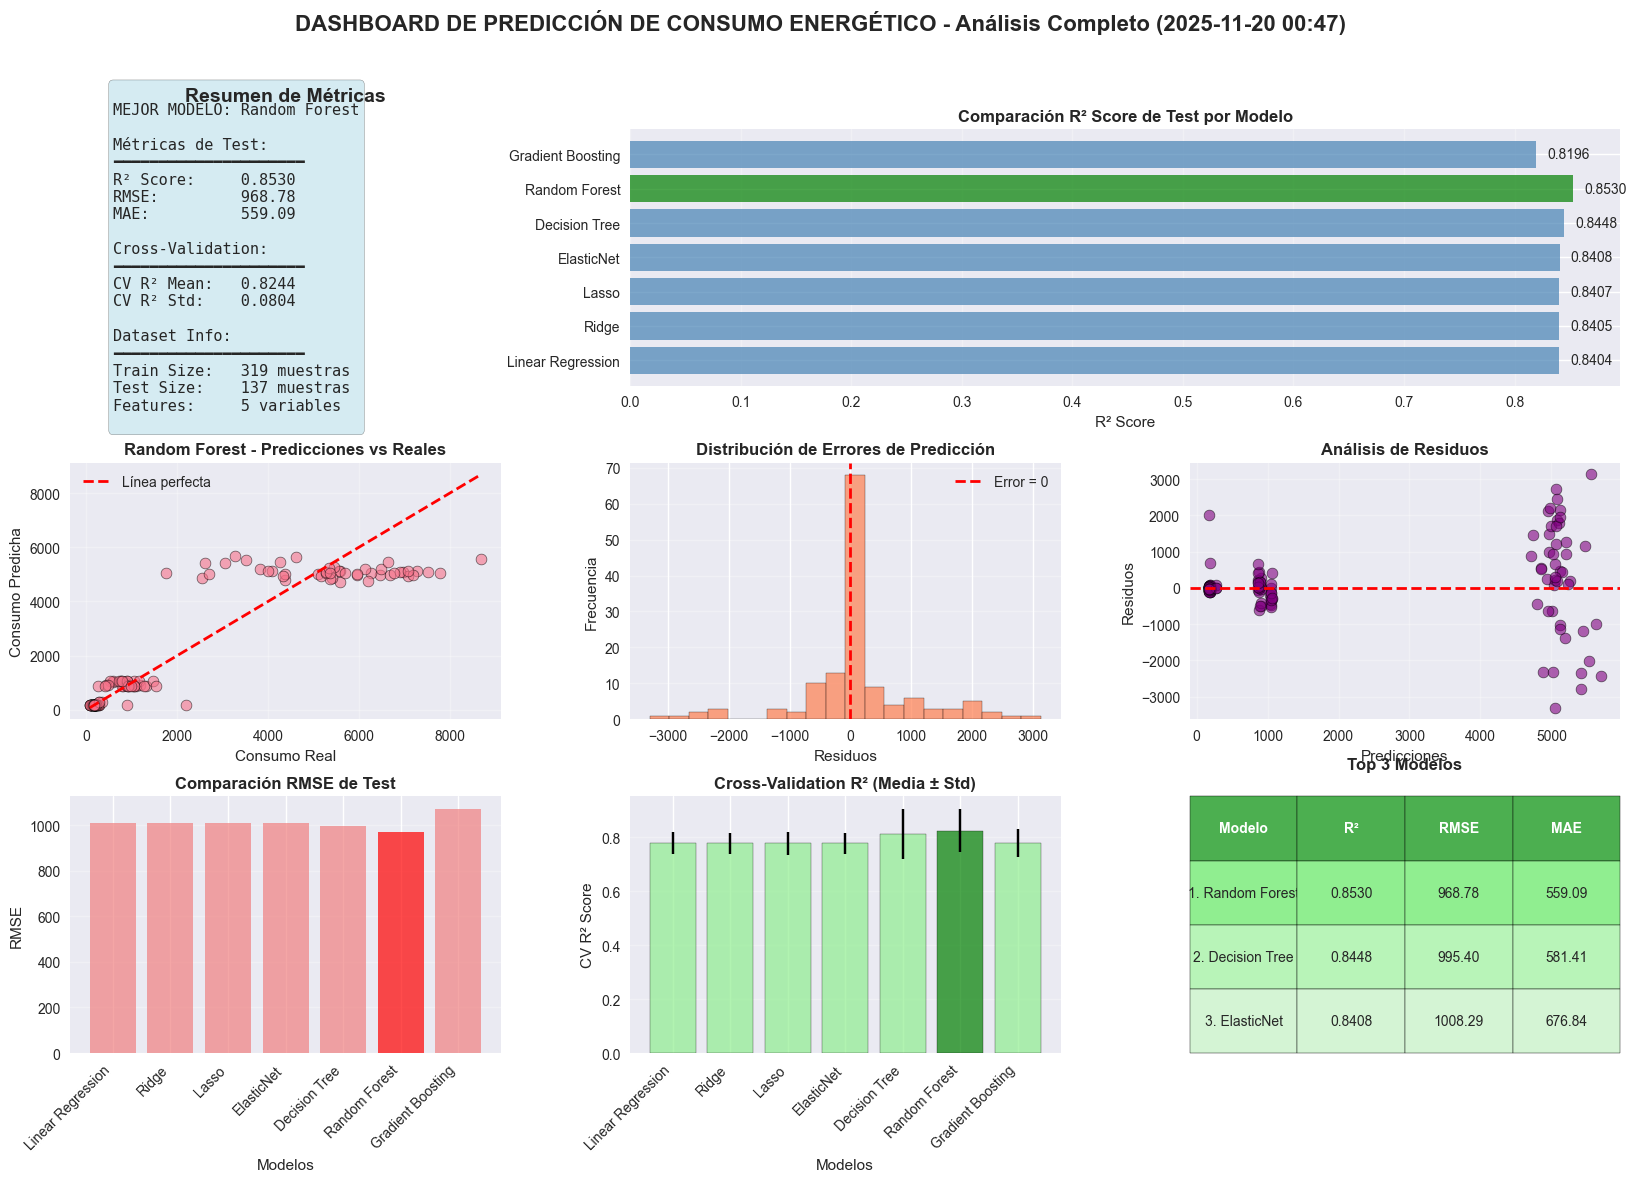

✓ Dashboard generado exitosamente


In [24]:
# Identificar el mejor modelo
best_model_name = results_sorted.index[0]

# Obtener predicciones del mejor modelo
if best_model_name == 'Random Forest':
    best_predictions = rf_pred
    best_model = rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = gb_pred
    best_model = gb
elif best_model_name == 'Decision Tree':
    best_predictions = dt_pred
    best_model = dt
elif best_model_name == 'Linear Regression':
    best_predictions = lr_pred
    best_model = lr
elif best_model_name == 'Ridge':
    best_predictions = ridge_pred
    best_model = ridge
elif best_model_name == 'Lasso':
    best_predictions = lasso_pred
    best_model = lasso
else:  # ElasticNet
    best_predictions = elastic_pred
    best_model = elastic


# Dashboard completo de resultados
from datetime import datetime

# Crear figura con subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Métricas del mejor modelo (superior izquierda)
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
best_metrics_text = f"""
MEJOR MODELO: {best_model_name}

Métricas de Test:
━━━━━━━━━━━━━━━━━━━━━
R² Score:     {results_sorted.loc[best_model_name, 'R2_test']:.4f}
RMSE:         {results_sorted.loc[best_model_name, 'RMSE_test']:.2f}
MAE:          {results_sorted.loc[best_model_name, 'MAE_test']:.2f}

Cross-Validation:
━━━━━━━━━━━━━━━━━━━━━
CV R² Mean:   {results_sorted.loc[best_model_name, 'CV_R2_mean']:.4f}
CV R² Std:    {results_sorted.loc[best_model_name, 'CV_R2_std']:.4f}

Dataset Info:
━━━━━━━━━━━━━━━━━━━━━
Train Size:   {X_train.shape[0]} muestras
Test Size:    {X_test.shape[0]} muestras
Features:     {X_train.shape[1]} variables
"""
ax1.text(0.1, 0.5, best_metrics_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax1.set_title('Resumen de Métricas', fontsize=14, fontweight='bold', pad=20)

# 2. Comparación R² de todos los modelos (superior centro y derecha)
ax2 = fig.add_subplot(gs[0, 1:])
models_list = list(results.keys())
r2_test_values = [results[model]['R2_test'] for model in models_list]
colors = ['green' if model == best_model_name else 'steelblue' for model in models_list]

bars = ax2.barh(models_list, r2_test_values, color=colors, alpha=0.7)
ax2.set_xlabel('R² Score', fontsize=11)
ax2.set_title('Comparación R² Score de Test por Modelo', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(r2_test_values):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

# 3. Predicciones vs Valores Reales (medio izquierda)
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test, best_predictions, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea perfecta')
ax3.set_xlabel('Consumo Real', fontsize=11)
ax3.set_ylabel('Consumo Predicha', fontsize=11)
ax3.set_title(f'{best_model_name} - Predicciones vs Reales', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Distribución de residuos (medio centro)
ax4 = fig.add_subplot(gs[1, 1])
residuals = y_test.values - best_predictions
ax4.hist(residuals, bins=20, alpha=0.7, color='coral', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
ax4.set_xlabel('Residuos', fontsize=11)
ax4.set_ylabel('Frecuencia', fontsize=11)
ax4.set_title('Distribución de Errores de Predicción', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Residuos vs Predicciones (medio derecha)
ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(best_predictions, residuals, alpha=0.6, s=60, color='purple', edgecolors='black', linewidth=0.5)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Predicciones', fontsize=11)
ax5.set_ylabel('Residuos', fontsize=11)
ax5.set_title('Análisis de Residuos', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Comparación RMSE (inferior izquierda)
ax6 = fig.add_subplot(gs[2, 0])
rmse_test_values = [results[model]['RMSE_test'] for model in models_list]
colors_rmse = ['red' if model == best_model_name else 'lightcoral' for model in models_list]
ax6.bar(range(len(models_list)), rmse_test_values, color=colors_rmse, alpha=0.7)
ax6.set_xlabel('Modelos', fontsize=11)
ax6.set_ylabel('RMSE', fontsize=11)
ax6.set_title('Comparación RMSE de Test', fontsize=12, fontweight='bold')
ax6.set_xticks(range(len(models_list)))
ax6.set_xticklabels(models_list, rotation=45, ha='right')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Cross-Validation Scores (inferior centro)
ax7 = fig.add_subplot(gs[2, 1])
cv_means = [results[model]['CV_R2_mean'] for model in models_list]
cv_stds = [results[model]['CV_R2_std'] for model in models_list]
colors_cv = ['green' if model == best_model_name else 'lightgreen' for model in models_list]
ax7.bar(range(len(models_list)), cv_means, yerr=cv_stds, capsize=5, 
        color=colors_cv, alpha=0.7, edgecolor='black')
ax7.set_xlabel('Modelos', fontsize=11)
ax7.set_ylabel('CV R² Score', fontsize=11)
ax7.set_title('Cross-Validation R² (Media ± Std)', fontsize=12, fontweight='bold')
ax7.set_xticks(range(len(models_list)))
ax7.set_xticklabels(models_list, rotation=45, ha='right')
ax7.grid(True, alpha=0.3, axis='y')

# 8. Tabla resumen top 3 modelos (inferior derecha)
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('tight')
ax8.axis('off')

top3_data = []
for i, (model_name, metrics) in enumerate(results_sorted.head(3).iterrows()):
    top3_data.append([
        f"{i+1}. {model_name}",
        f"{metrics['R2_test']:.4f}",
        f"{metrics['RMSE_test']:.2f}",
        f"{metrics['MAE_test']:.2f}"
    ])

table = ax8.table(cellText=top3_data,
                 colLabels=['Modelo', 'R²', 'RMSE', 'MAE'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilizar encabezados
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Estilizar filas
colors_table = ['#90EE90', '#B8F4B8', '#D4F4D4']
for i in range(1, 4):
    for j in range(4):
        table[(i, j)].set_facecolor(colors_table[i-1])

ax8.set_title('Top 3 Modelos', fontsize=12, fontweight='bold', pad=20)

# Título general del dashboard
fig.suptitle(f'DASHBOARD DE PREDICCIÓN DE CONSUMO ENERGÉTICO - Análisis Completo ({datetime.now().strftime("%Y-%m-%d %H:%M")})', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

print("✓ Dashboard generado exitosamente")

## 6.5 Dashboard de Visualización de Resultados

## 7. Análisis del Mejor Modelo

In [25]:
import os
from pathlib import Path

# Resumen completo de archivos generados
def mostrar_resumen_archivos():
    """Muestra un resumen completo de todos los archivos generados durante el análisis"""
    
    print("\n" + "=" * 80)
    print("📋 RESUMEN DE ARCHIVOS GENERADOS - ANÁLISIS DE PREDICCIÓN DE CONSUMO ENERGÉTICO")
    print("=" * 80)
    print(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Mejor modelo seleccionado: {best_model_name}")
    print(f"Métricas del modelo: R²={results_sorted.loc[best_model_name, 'R2_test']:.4f}, " + 
          f"RMSE={results_sorted.loc[best_model_name, 'RMSE_test']:.2f}")
    print("=" * 80)
    
    # Recolectar información de archivos
    archivos_info = []
    
    # 1. Modelo guardado
    if 'archivos_modelo' in globals():
        pkl_file, joblib_file, json_file = archivos_modelo
        
        archivos_info.append({
            'categoria': '🤖 MODELO ENTRENADO',
            'archivos': [
                {'nombre': pkl_file, 'descripcion': 'Modelo en formato Pickle'},
                {'nombre': joblib_file, 'descripcion': 'Modelo en formato Joblib (recomendado)'},
                {'nombre': json_file, 'descripcion': 'Metadatos del modelo en JSON'}
            ]
        })
    
    # 2. Reporte Excel
    if 'archivo_reporte' in globals():
        archivos_info.append({
            'categoria': '📊 REPORTE DE ANÁLISIS',
            'archivos': [
                {'nombre': archivo_reporte, 'descripcion': 'Reporte completo con 4 hojas (Ejecutivo, Modelos, Predicciones, Variables)'}
            ]
        })
    
    # 3. Archivo de ejemplo
    if 'archivo_ejemplo' in globals():
        archivos_info.append({
            'categoria': '📝 DATOS DE EJEMPLO',
            'archivos': [
                {'nombre': archivo_ejemplo, 'descripcion': 'Plantilla con datos de ejemplo para predicciones'}
            ]
        })
    
    # 4. Predicciones realizadas
    if 'archivo_predicciones' in globals():
        archivos_info.append({
            'categoria': '🔮 PREDICCIONES',
            'archivos': [
                {'nombre': archivo_predicciones, 'descripcion': 'Resultados de predicciones con datos de ejemplo'}
            ]
        })
    
    # Mostrar información organizada
    contador = 0
    for grupo in archivos_info:
        print(f"\n{grupo['categoria']}")
        print("-" * 80)
        for archivo in grupo['archivos']:
            contador += 1
            nombre = archivo['nombre']
            desc = archivo['descripcion']
            
            # Verificar si existe y obtener tamaño
            if os.path.exists(nombre):
                tamaño = os.path.getsize(nombre)
                if tamaño < 1024:
                    tamaño_str = f"{tamaño} bytes"
                elif tamaño < 1024 * 1024:
                    tamaño_str = f"{tamaño/1024:.2f} KB"
                else:
                    tamaño_str = f"{tamaño/(1024*1024):.2f} MB"
                
                print(f"  {contador}. ✓ {nombre}")
                print(f"     → {desc}")
                print(f"     → Tamaño: {tamaño_str}")
            else:
                print(f"  {contador}. ⚠ {nombre} (no encontrado)")
                print(f"     → {desc}")
    
    # Resumen final
    print("\n" + "=" * 80)
    print(f"TOTAL DE ARCHIVOS GENERADOS: {contador}")
    print("=" * 80)
    
    # Tabla resumen
    print("\n📦 CONTENIDO DE LOS ARCHIVOS:")
    print("-" * 80)
    
    resumen_contenido = [
        ["Archivo", "Contenido Principal"],
        ["-" * 35, "-" * 43],
        ["Modelo (.pkl/.joblib)", "Modelo entrenado + Scaler + Imputer + LabelEncoder"],
        ["Metadatos (.json)", "Información del modelo, métricas y parámetros"],
        ["Reporte Excel", "4 hojas: Resumen, Comparación, Predicciones, Variables"],
        ["Datos Ejemplo", "Plantilla para nuevas predicciones (10 registros)"],
        ["Predicciones Excel", "Resultados + Estadísticas de predicciones"],
    ]
    
    for fila in resumen_contenido:
        print(f"  {fila[0]:<35} | {fila[1]:<43}")
    
    print("\n" + "=" * 80)
    print("💡 INSTRUCCIONES DE USO:")
    print("-" * 80)
    print("""
  1. PARA REALIZAR NUEVAS PREDICCIONES:
     • Prepare un archivo Excel con las columnas requeridas
     • Use: predecir_desde_excel('su_archivo.xlsx')
     
  2. PARA CARGAR EL MODELO EN OTRA SESIÓN:
     • import joblib
     • modelo = joblib.load('archivo_modelo.joblib')
     • predicciones = modelo['modelo'].predict(datos_nuevos)
     
  3. PARA REVISAR RESULTADOS:
     • Abra el archivo de reporte Excel
     • Revise cada hoja para análisis detallado
     
  4. PARA COMPARTIR EL MODELO:
     • Envíe el archivo .joblib y el .json
     • El receptor necesitará scikit-learn instalado
""")
    print("=" * 80)
    
    # Guardar resumen en archivo de texto
    resumen_filename = f"RESUMEN_ARCHIVOS_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    with open(resumen_filename, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("RESUMEN DE ARCHIVOS GENERADOS - ANÁLISIS DE PREDICCIÓN DE CONSUMO ENERGÉTICO\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Mejor modelo: {best_model_name}\n")
        f.write(f"R² Score: {results_sorted.loc[best_model_name, 'R2_test']:.4f}\n")
        f.write(f"RMSE: {results_sorted.loc[best_model_name, 'RMSE_test']:.2f}\n\n")
        
        for grupo in archivos_info:
            f.write(f"\n{grupo['categoria']}\n")
            f.write("-" * 80 + "\n")
            for archivo in grupo['archivos']:
                f.write(f"  • {archivo['nombre']}\n")
                f.write(f"    {archivo['descripcion']}\n")
        
        f.write(f"\n\nTotal de archivos: {contador}\n")
    
    print(f"\n✓ Resumen guardado en: {resumen_filename}\n")
    
    return archivos_info


# Generar resumen (solo si hay archivos generados)
if 'best_model_name' in globals():
    resumen = mostrar_resumen_archivos()
else:
    print('⚠ Ejecute primero todas las celdas anteriores para generar los archivos')


📋 RESUMEN DE ARCHIVOS GENERADOS - ANÁLISIS DE PREDICCIÓN DE CONSUMO ENERGÉTICO
Fecha: 2025-11-20 00:47:13
Mejor modelo seleccionado: Random Forest
Métricas del modelo: R²=0.8530, RMSE=968.78

📊 REPORTE DE ANÁLISIS
--------------------------------------------------------------------------------
  1. ✓ Reporte_Consumo_ML_20251120_004705.xlsx
     → Reporte completo con 4 hojas (Ejecutivo, Modelos, Predicciones, Variables)
     → Tamaño: 14.10 KB

TOTAL DE ARCHIVOS GENERADOS: 1

📦 CONTENIDO DE LOS ARCHIVOS:
--------------------------------------------------------------------------------
  Archivo                             | Contenido Principal                        
  ----------------------------------- | -------------------------------------------
  Modelo (.pkl/.joblib)               | Modelo entrenado + Scaler + Imputer + LabelEncoder
  Metadatos (.json)                   | Información del modelo, métricas y parámetros
  Reporte Excel                       | 4 hojas: Resumen, Compa

## 11. Resumen de Archivos Generados

In [26]:
# Realizar predicciones con el archivo de ejemplo

# Realizar predicciones (solo si el modelo y archivo están listos)
if 'best_model' in globals() and 'archivo_ejemplo' in globals():
    print("\n🔮 REALIZANDO PREDICCIONES DE PRUEBA...")
    print("-" * 70)
    resultados_prediccion, archivo_predicciones = predecir_desde_excel(archivo_ejemplo)
else:
    print('⚠ Ejecute primero las celdas anteriores para entrenar el modelo y crear el archivo de ejemplo')

⚠ Ejecute primero las celdas anteriores para entrenar el modelo y crear el archivo de ejemplo


In [27]:
def predecir_desde_excel(archivo_excel, nombre_hoja='Datos Nuevos'):
    """
    Carga datos nuevos desde un archivo Excel y realiza predicciones
    
    Parámetros:
    -----------
    archivo_excel : str
        Ruta al archivo Excel con datos nuevos
    nombre_hoja : str
        Nombre de la hoja con los datos (por defecto 'Datos Nuevos')
    
    El archivo Excel debe contener las siguientes columnas:
    - NDVI Outlier Manual
    - NDRE Outlier Manual
    - PRECIPITACION Outlier Manual
    - DIAS SIN LLUVIA Estadistica
    - Tipo_suelo (Arenoso, Arcilloso o Franco)
    
    Retorna:
    --------
    DataFrame con predicciones y archivo Excel con resultados
    """
    
    try:
        # Cargar datos nuevos
        print(f"Cargando datos desde: {archivo_excel}")
        df_nuevo = pd.read_excel(archivo_excel, sheet_name=nombre_hoja)
        print(f"✓ Datos cargados: {df_nuevo.shape[0]} registros")
        
        # Verificar columnas requeridas
        columnas_requeridas = [
            'NDVI Outlier Manual',
            'NDRE Outlier Manual',
            'PRECIPITACION Outlier Manual',
            'DIAS SIN LLUVIA Estadistica',
            'Tipo_suelo'
        ]
        
        columnas_faltantes = [col for col in columnas_requeridas if col not in df_nuevo.columns]
        if columnas_faltantes:
            print(f"❌ Error: Faltan las siguientes columnas: {columnas_faltantes}")
            return None
        
        print("✓ Todas las columnas requeridas están presentes")
        
        # Preparar datos
        X_nuevo = df_nuevo[columnas_requeridas].copy()
        
        # Codificar tipo de suelo
        X_nuevo['Tipo_suelo'] = le.fit_transform(X_nuevo['Tipo_suelo'].astype(str))
        
        # Imputar valores nulos si existen
        print(f"Valores nulos encontrados: {X_nuevo.isnull().sum().sum()}")
        if X_nuevo.isnull().sum().sum() > 0:
            X_nuevo = pd.DataFrame(imputer.transform(X_nuevo), columns=X_nuevo.columns)
            print("✓ Valores nulos imputados")
        
        # Escalar datos (solo para modelos que requieren escalado)
        modelos_con_escalado = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']
        if best_model_name in modelos_con_escalado:
            X_nuevo_proc = scaler.transform(X_nuevo)
            print(f"✓ Datos escalados (modelo {best_model_name} requiere escalado)")
        else:
            X_nuevo_proc = X_nuevo.values
            print(f"✓ Datos sin escalar (modelo {best_model_name} no requiere escalado)")
        
        # Realizar predicciones
        modelo_prediccion = best_model.best_estimator_ if hasattr(best_model, 'best_estimator_') else best_model
        predicciones = modelo_prediccion.predict(X_nuevo_proc)
        
        # Categorizar predicciones
        def categorizar_consumo_energético(valor):
            if valor < 3000:
                return 'Baja'
            elif valor < 5000:
                return 'Media'
            else:
                return 'Alta'
        
        categorias = [categorizar_consumo_energético(p) for p in predicciones]
        
        # Crear DataFrame de resultados
        df_resultados = df_nuevo.copy()
        df_resultados['Consumo_Predicha'] = np.round(predicciones, 2)
        df_resultados['Categoria_Predicha'] = categorias
        df_resultados['Modelo_Utilizado'] = best_model_name
        df_resultados['Fecha_Prediccion'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Guardar resultados en Excel
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        archivo_salida = f'Predicciones_Consumo_{timestamp}.xlsx'
        
        with pd.ExcelWriter(archivo_salida, engine='openpyxl') as writer:
            # Hoja 1: Predicciones completas
            df_resultados.to_excel(writer, sheet_name='Predicciones', index=False)
            
            # Hoja 2: Resumen estadístico
            resumen = pd.DataFrame({
                'Métrica': [
                    'Total de predicciones',
                    'Consumo promedio predicha',
                    'Consumo mínima predicha',
                    'Consumo máxima predicha',
                    'Desviación estándar',
                    '% Baja (<3000)',
                    '% Media (3000-5000)',
                    '% Alta (>5000)',
                    'Modelo utilizado',
                    'R² del modelo',
                    'RMSE del modelo'
                ],
                'Valor': [
                    len(predicciones),
                    f"{np.mean(predicciones):.2f}",
                    f"{np.min(predicciones):.2f}",
                    f"{np.max(predicciones):.2f}",
                    f"{np.std(predicciones):.2f}",
                    f"{(np.sum(predicciones < 3000) / len(predicciones) * 100):.1f}%",
                    f"{(np.sum((predicciones >= 3000) & (predicciones < 5000)) / len(predicciones) * 100):.1f}%",
                    f"{(np.sum(predicciones >= 5000) / len(predicciones) * 100):.1f}%",
                    best_model_name,
                    f"{results_sorted.loc[best_model_name, 'R2_test']:.4f}",
                    f"{results_sorted.loc[best_model_name, 'RMSE_test']:.2f}"
                ]
            })
            resumen.to_excel(writer, sheet_name='Resumen', index=False)
            
            # Formatear hojas
            workbook = writer.book
            
            # Formatear hoja de predicciones
            ws_pred = workbook['Predicciones']
            for cell in ws_pred[1]:
                cell.font = Font(bold=True, color="FFFFFF")
                cell.fill = PatternFill(start_color="4CAF50", end_color="4CAF50", fill_type="solid")
                cell.alignment = Alignment(horizontal='center')
            
            # Formatear hoja de resumen
            ws_res = workbook['Resumen']
            for cell in ws_res[1]:
                cell.font = Font(bold=True, color="FFFFFF")
                cell.fill = PatternFill(start_color="2196F3", end_color="2196F3", fill_type="solid")
                cell.alignment = Alignment(horizontal='center')
            
            ws_res.column_dimensions['A'].width = 30
            ws_res.column_dimensions['B'].width = 25
        
        print("\n" + "=" * 70)
        print("✓ PREDICCIONES COMPLETADAS EXITOSAMENTE")
        print("=" * 70)
        print(f"Registros procesados: {len(predicciones)}")
        print(f"Archivo de salida: {archivo_salida}")
        print(f"\nEstadísticas de las predicciones:")
        print(f"  - Promedio: {np.mean(predicciones):.2f}")
        print(f"  - Mínimo: {np.min(predicciones):.2f}")
        print(f"  - Máximo: {np.max(predicciones):.2f}")
        print(f"\nDistribución por categoría:")
        print(f"  - Baja (<3000): {np.sum(predicciones < 3000)} ({np.sum(predicciones < 3000)/len(predicciones)*100:.1f}%)")
        print(f"  - Media (3000-5000): {np.sum((predicciones >= 3000) & (predicciones < 5000))} ({np.sum((predicciones >= 3000) & (predicciones < 5000))/len(predicciones)*100:.1f}%)")
        print(f"  - Alta (>5000): {np.sum(predicciones >= 5000)} ({np.sum(predicciones >= 5000)/len(predicciones)*100:.1f}%)")
        print("=" * 70)
        
        return df_resultados, archivo_salida
        
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo {archivo_excel}")
        return None
    except Exception as e:
        print(f"❌ Error al procesar datos: {str(e)}")
        return None

# Ejemplo de cómo usar la función (comentado por ahora)
# Crear un archivo de ejemplo para demostración
def crear_excel_ejemplo():
    """Crea un archivo Excel de ejemplo para predicciones"""
    
    # Generar datos de ejemplo
    np.random.seed(42)
    n_ejemplos = 10
    
    datos_ejemplo = pd.DataFrame({
        'NDVI Outlier Manual': np.random.uniform(0.2, 0.9, n_ejemplos),
        'NDRE Outlier Manual': np.random.uniform(0.1, 0.6, n_ejemplos),
        'PRECIPITACION Outlier Manual': np.random.uniform(0, 100, n_ejemplos),
        'DIAS SIN LLUVIA Estadistica': np.random.randint(1, 15, n_ejemplos),
        'Tipo_suelo': np.random.choice(['Arenoso', 'Arcilloso', 'Franco'], n_ejemplos)
    })
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'Datos_Nuevos_Ejemplo_{timestamp}.xlsx'
    datos_ejemplo.to_excel(filename, sheet_name='Datos Nuevos', index=False)
    
    print(f"✓ Archivo de ejemplo creado: {filename}")
    print(f"  Contiene {n_ejemplos} registros de ejemplo")
    print(f"\nPara realizar predicciones, use:")
    print(f"  resultados, archivo = predecir_desde_excel('{filename}')")
    
    return filename

# Crear archivo de ejemplo
archivo_ejemplo = crear_excel_ejemplo()

✓ Archivo de ejemplo creado: Datos_Nuevos_Ejemplo_20251120_004714.xlsx
  Contiene 10 registros de ejemplo

Para realizar predicciones, use:
  resultados, archivo = predecir_desde_excel('Datos_Nuevos_Ejemplo_20251120_004714.xlsx')


## 10. Función de Predicción de Nuevos Datos desde Excel

In [28]:
import pickle
import joblib
import json

# Guardar el mejor modelo y objetos necesarios
def guardar_modelo_completo():
    """
    Guarda el mejor modelo entrenado junto con todos los objetos necesarios
    para realizar predicciones futuras
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("=" * 70)
    print("GUARDANDO MODELO PARA SISTEMA DE PREDICCIÓN EN EXCEL")
    print("=" * 70)
    
    # 1. Guardar el modelo (solo el modelo, sin otros objetos)
    modelo_final = best_model.best_estimator_ if hasattr(best_model, 'best_estimator_') else best_model
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(modelo_final, f)
    print("✓ Modelo guardado: best_model.pkl")
    
    # 2. Guardar el scaler
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("✓ Scaler guardado: scaler.pkl")
    
    # 3. Guardar información del modelo en JSON (para el sistema de predicción)
    model_info = {
        'model_name': best_model_name,
        'fecha_entrenamiento': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'metricas': {
            'R2_test': float(results_sorted.loc[best_model_name, 'R2_test']),
            'RMSE_test': float(results_sorted.loc[best_model_name, 'RMSE_test']),
            'MAE_test': float(results_sorted.loc[best_model_name, 'MAE_test']),
            'CV_R2_mean': float(results_sorted.loc[best_model_name, 'CV_R2_mean']),
            'CV_R2_std': float(results_sorted.loc[best_model_name, 'CV_R2_std'])
        },
        'feature_names': X_clean.columns.tolist(),
        'n_features': len(X_clean.columns),
        'n_train_samples': X_train.shape[0],
        'n_test_samples': X_test.shape[0],
        'hiperparametros': str(best_model.best_params_) if hasattr(best_model, 'best_params_') else 'N/A'
    }
    
    with open('model_info.json', 'w', encoding='utf-8') as f:
        json.dump(model_info, f, indent=2, ensure_ascii=False)
    print("✓ Información guardada: model_info.json")
    
    # 4. OPCIONAL: Guardar backup completo con timestamp
    modelo_completo = {
        'modelo': modelo_final,
        'scaler': scaler,
        'imputer': imputer,
        'label_encoder': le,
        'feature_names': X_clean.columns.tolist(),
        'modelo_nombre': best_model_name,
        'metricas': model_info['metricas'],
        'fecha_entrenamiento': timestamp,
        'n_entrenamiento': X_train.shape[0],
        'n_test': X_test.shape[0],
    }
    
    # Backup con timestamp
    backup_filename = f'modelo_consumo energético_backup_{timestamp}.pkl'
    with open(backup_filename, 'wb') as f:
        pickle.dump(modelo_completo, f)
    print(f"✓ Backup guardado: {backup_filename}")
    
    print("\n" + "=" * 70)
    print("RESUMEN DEL MODELO GUARDADO")
    print("=" * 70)
    print(f"Modelo: {best_model_name}")
    print(f"R² Score: {model_info['metricas']['R2_test']:.4f}")
    print(f"RMSE: {model_info['metricas']['RMSE_test']:.2f}")
    print(f"MAE: {model_info['metricas']['MAE_test']:.2f}")
    print(f"Variables predictoras: {len(model_info['feature_names'])}")
    print("\nVariables:")
    for i, var in enumerate(model_info['feature_names'], 1):
        print(f"  {i}. {var}")
    
    print("\n" + "=" * 70)
    print("ARCHIVOS GENERADOS PARA SISTEMA DE PREDICCIÓN:")
    print("=" * 70)
    print("  ✓ best_model.pkl  → Modelo entrenado")
    print("  ✓ scaler.pkl      → Escalador de datos")
    print("  ✓ model_info.json → Información del modelo")
    print(f"  ✓ {backup_filename} → Backup completo")
    print("\n" + "=" * 70)
    print("PRÓXIMOS PASOS:")
    print("=" * 70)
    print("1. Ejecuta: python 2_crear_plantilla_excel.py")
    print("2. Llena los datos en el Excel generado")
    print("3. Ejecuta: python 3_predecir_en_excel.py")
    print("4. Abre el Excel para ver las predicciones")
    print("=" * 70)
    
    return 'best_model.pkl', 'scaler.pkl', 'model_info.json', backup_filename


# Guardar modelo (solo si está entrenado)
if 'best_model' in globals() and 'best_model_name' in globals():
    archivos_modelo = guardar_modelo_completo()
else:
    print('⚠ Ejecute primero las celdas que entrenan y evalúan los modelos')


GUARDANDO MODELO PARA SISTEMA DE PREDICCIÓN EN EXCEL
✓ Modelo guardado: best_model.pkl
✓ Scaler guardado: scaler.pkl
✓ Información guardada: model_info.json
✓ Backup guardado: modelo_consumo energético_backup_20251120_004716.pkl

RESUMEN DEL MODELO GUARDADO
Modelo: Random Forest
R² Score: 0.8530
RMSE: 968.78
MAE: 559.09
Variables predictoras: 5

Variables:
  1. Sector
  2. Estrato
  3. Ciudad
  4. Area_m2
  5. Puede_Pagar_Solar

ARCHIVOS GENERADOS PARA SISTEMA DE PREDICCIÓN:
  ✓ best_model.pkl  → Modelo entrenado
  ✓ scaler.pkl      → Escalador de datos
  ✓ model_info.json → Información del modelo
  ✓ modelo_consumo energético_backup_20251120_004716.pkl → Backup completo

PRÓXIMOS PASOS:
1. Ejecuta: python 2_crear_plantilla_excel.py
2. Llena los datos en el Excel generado
3. Ejecuta: python 3_predecir_en_excel.py
4. Abre el Excel para ver las predicciones


## 9. Descarga y Guardado del Mejor Modelo

In [29]:
# Identificar el mejor modelo basado en R2 de test
best_model_name = results_sorted.index[0]
print(f"Mejor modelo: {best_model_name}")
print(f"R² de test: {results_sorted.loc[best_model_name, 'R2_test']:.4f}")
print(f"RMSE de test: {results_sorted.loc[best_model_name, 'RMSE_test']:.4f}")

# Obtener predicciones del mejor modelo
if best_model_name == 'Random Forest':
    best_predictions = rf_pred
    best_model = rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = gb_pred
    best_model = gb
elif best_model_name == 'Decision Tree':
    best_predictions = dt_pred
    best_model = dt
elif best_model_name == 'Linear Regression':
    best_predictions = lr_pred
    best_model = lr
elif best_model_name == 'Ridge':
    best_predictions = ridge_pred
    best_model = ridge
elif best_model_name == 'Lasso':
    best_predictions = lasso_pred
    best_model = lasso
else:  # ElasticNet
    best_predictions = elastic_pred
    best_model = elastic

Mejor modelo: Random Forest
R² de test: 0.8530
RMSE de test: 968.7818


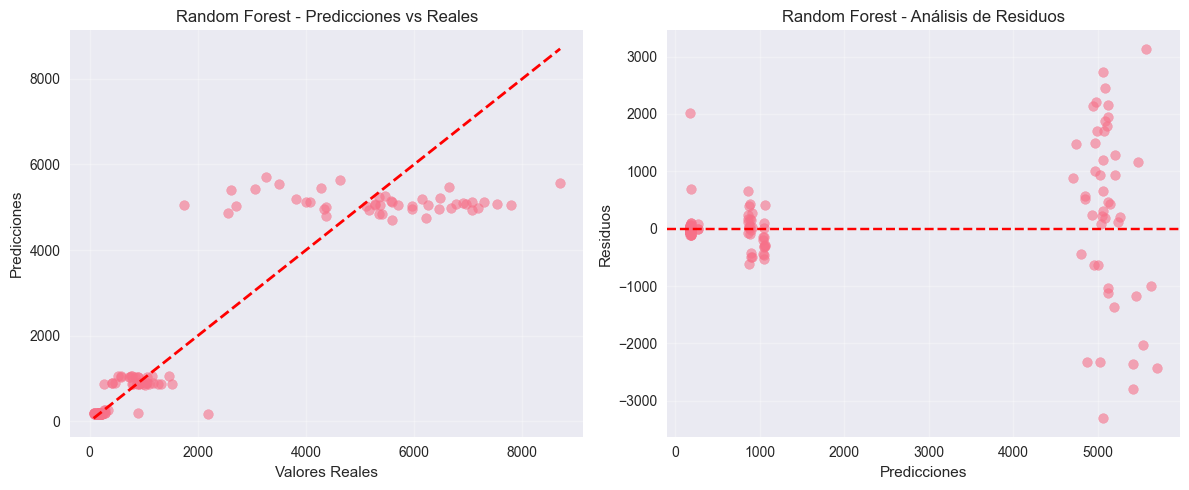

In [30]:
# Verificar y definir variables necesarias
if 'best_model_name' not in globals():
    best_model_name = results_sorted.index[0]

# Obtener predicciones del mejor modelo
if 'best_predictions' not in globals():
    if best_model_name == 'Random Forest':
        best_predictions = rf_pred
        best_model = rf
    elif best_model_name == 'Gradient Boosting':
        best_predictions = gb_pred
        best_model = gb
    elif best_model_name == 'Decision Tree':
        best_predictions = dt_pred
        best_model = dt
    elif best_model_name == 'Linear Regression':
        best_predictions = lr_pred
        best_model = lr
    elif best_model_name == 'Ridge':
        best_predictions = ridge_pred
        best_model = ridge
    elif best_model_name == 'Lasso':
        best_predictions = lasso_pred
        best_model = lasso
    else:  # ElasticNet
        best_predictions = elastic_pred
        best_model = elastic

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'{best_model_name} - Predicciones vs Reales')
plt.grid(True, alpha=0.3)

# Residuos
plt.subplot(1, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title(f'{best_model_name} - Análisis de Residuos')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Resumen y Conclusiones

In [31]:
print("=== RESUMEN FINAL ===")
print(f"Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Dataset para modelado: {X_clean.shape[0]} filas, {X_clean.shape[1]} variables predictoras")
print(f"División: {X_train.shape[0]} entrenamiento, {X_test.shape[0]} prueba")
print(f"\nMejor modelo: {best_model_name}")
print(f"R² de test: {results_sorted.loc[best_model_name, 'R2_test']:.4f}")
print(f"RMSE de test: {results_sorted.loc[best_model_name, 'RMSE_test']:.4f}")
print(f"MAE de test: {results_sorted.loc[best_model_name, 'MAE_test']:.4f}")

print("\n=== TOP 3 MODELOS ===")
for i, (model_name, metrics) in enumerate(results_sorted.head(3).iterrows()):
    print(f"{i+1}. {model_name}: R²={metrics['R2_test']:.4f}, RMSE={metrics['RMSE_test']:.4f}")

# Si el mejor modelo es Random Forest o Gradient Boosting, mostrar importancia de características
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print("\n=== IMPORTANCIA DE CARACTERÍSTICAS ===")
    if best_model_name == 'Random Forest':
        print(feature_importance.to_string(index=False))

=== RESUMEN FINAL ===
Dataset original: 460 filas, 9 columnas
Dataset para modelado: 456 filas, 5 variables predictoras
División: 319 entrenamiento, 137 prueba

Mejor modelo: Random Forest
R² de test: 0.8530
RMSE de test: 968.7818
MAE de test: 559.0940

=== TOP 3 MODELOS ===
1. Random Forest: R²=0.8530, RMSE=968.7818
2. Decision Tree: R²=0.8448, RMSE=995.3994
3. ElasticNet: R²=0.8408, RMSE=1008.2887

=== IMPORTANCIA DE CARACTERÍSTICAS ===
          feature  importance
          Area_m2    0.975060
           Sector    0.018119
           Ciudad    0.004466
          Estrato    0.001910
Puede_Pagar_Solar    0.000445
